# Soybean meal & Soybean oil MACD peak and trough trading strategy

Soybean Meal and Soybean Oil MACD Trading Strategy
----------------------------------

Problem:
Soybean meal is a globally traded agricultural commodity with high price volatility 
driven by supply-demand dynamics, weather, and global trade policies. 
Traders and risk managers need systematic tools to capture trends and reduce 
reliance on subjective decision-making.

Goal:
This notebook develops and backtests a trading strategy based on the 
Moving Average Convergence Divergence (MACD) indicator, focusing on peak 
and trough signals. We evaluate the strategy’s profitability, risk profile, 
and robustness against benchmarks.

Objectives:
1. Import and preprocess soybean meal futures data
2. Implement MACD peak and trough signal generation
3. Backtest strategy performance
4. Evaluate results using key metrics (returns, volatility, drawdowns)
5. Provide insights for traders, portfolio managers, and risk management teams

## Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Layer, Dense, Input, Dropout, LSTM, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime, timedelta
from math import sqrt
import os

warnings.filterwarnings('ignore')

# Constructing customized trading period & Initializing contract
## 1. Special Date Period Identification
- **Purpose**: Identifies if a date falls within the one-week period before major Chinese holidays
- **Holidays tracked**: 
  - National Day (October 1st annually)
  - Spring Festival (variable dates 2019-2025)
- **Purpose**: Checks if date falls within designated "rest periods"
- **Period definition**: Three-week windows around the 10th of April, August, and December
-  Determines if the next trading day is a rest period


## 2. Futures Contract Management
- Identifies the active soybean meal / oil futures contract for a given date
- Determines if a soybean meal / oil position should be closed due to contract rollover

## Set trading period

In [3]:
def is_before_major_holiday(date):
    "Check if it is within one week before major holidays"
    # Convert the date to a datetime object
    date = pd.to_datetime(date)
    
    # Define the Major holidays of each year (National Day and Spring Festival)
    years = range(2019, 2026)
    holiday_dates = []
    
    for year in years:
        # National Day (October 1st)
        national_day = pd.Timestamp(f"{year}-10-01")
        # Spring Festival (Lunar New Year, here the approximate date range is used)
        if year == 2019:
            spring_festival = pd.Timestamp(f"{year}-02-05")
        elif year == 2020:
            spring_festival = pd.Timestamp(f"{year}-01-25")
        elif year == 2021:
            spring_festival = pd.Timestamp(f"{year}-02-12")
        elif year == 2022:
            spring_festival = pd.Timestamp(f"{year}-02-01")
        elif year == 2023:
            spring_festival = pd.Timestamp(f"{year}-01-22")
        elif year == 2024:
            spring_festival = pd.Timestamp(f"{year}-02-10")
        elif year == 2025:
            spring_festival = pd.Timestamp(f"{year}-01-29")
        
        holiday_dates.extend([national_day, spring_festival])
    
    # Check if it is within one week before any holidays
    for holiday in holiday_dates:
        if holiday - timedelta(days=7) <= date <= holiday:
            return True
    
    return False

def is_rest_period(date):
    """
    Check whether it is during the break period (no trading in the week before, during and after the 10th of April, August and December)
    """
    date = pd.to_datetime(date)
    month = date.month
    
    # Only check April, August and December
    if month not in [4, 8, 12]:
        return False
        
    # Get the date of the 10th of the month
    tenth_day = pd.Timestamp(year=date.year, month=month, day=10)
    
    # Get the Monday of the week where number 10 is located
    current_week_monday = tenth_day - pd.Timedelta(days=tenth_day.dayofweek)
    
    # Calculate the start of the previous week and the end of the following week
    start_of_rest = current_week_monday - pd.Timedelta(days=7)  # Monday of the previous week
    end_of_rest = current_week_monday + pd.Timedelta(days=21)   # The weekend of the following week (plus 21 days)
    
    # Check if the date is within these three weeks
    return start_of_rest <= date <= end_of_rest

def is_next_day_rest_period(date):
    """
    Check whether the next trading day is a rest period
    """
    next_day = pd.to_datetime(date) + pd.Timedelta(days=1)
    return is_rest_period(next_day)

## Get contract information and close condition

In [4]:
def get_meal_contract_info(date):
    """
    Determine the soybean meal contract that should be traded at present based on the date
    Return: (Contract code, contract expiration date)
    """
    date = pd.to_datetime(date)
    
    # Define the deadline for soybean meal contracts
    contract_dates = {
        '2401': pd.Timestamp('2023-12-08'),
        '2405': pd.Timestamp('2024-04-01'),
        '2409': pd.Timestamp('2024-08-13'),
        '2501': pd.Timestamp('2024-11-14'),
        '2505': pd.Timestamp('2025-04-03')
    }
    
    # Find the right contract
    current_contract = None
    contract_end_date = None
    
    for contract, end_date in contract_dates.items():
        if date <= end_date:
            if current_contract is None or contract_dates[current_contract] > end_date:
                current_contract = contract
                contract_end_date = end_date
    
    return current_contract, contract_end_date

def get_oil_contract_info(date):
    """
    Determine the soybean oil contract that should be traded at present based on the date
    Return: (Contract code, contract expiration date)
    """
    date = pd.to_datetime(date)
    
    # Define the expiration date of soybean oil contracts
    contract_dates = {
        '2401': pd.Timestamp('2023-12-12'),
        '2405': pd.Timestamp('2024-04-03'),
        '2409': pd.Timestamp('2024-08-12'),
        '2501': pd.Timestamp('2024-12-03'),
        '2505': pd.Timestamp('2025-04-07')
    }
    
    # Find the right contract
    current_contract = None
    contract_end_date = None
    
    for contract, end_date in contract_dates.items():
        if date <= end_date:
            if current_contract is None or contract_dates[current_contract] > end_date:
                current_contract = contract
                contract_end_date = end_date
    
    return current_contract, contract_end_date

def should_close_meal_position(current_date, entry_date):
    """
    Determine whether soybean meal needs to be closed out due to contract switching
    """
    if entry_date is None:
        return False
        
    current_contract, _ = get_meal_contract_info(current_date)
    entry_contract, _ = get_meal_contract_info(entry_date)
    
    return current_contract != entry_contract

def should_close_oil_position(current_date, entry_date):
    """
    Determine whether soybean oil needs to be closed out due to contract switching
    """
    if entry_date is None:
        return False
        
    current_contract, _ = get_oil_contract_info(current_date)
    entry_contract, _ = get_oil_contract_info(entry_date)
    
    return current_contract != entry_contract

# Data Processing and Outlier Detection Analysis
## 1. Data Loading and Preprocessing
### Soybean Meal Data
- **Source**: Reads from 'soybean_meal_2019-2025.xlsx'
- **Processing Steps**:
  - Filters out future dates (keeps only dates ≤ current date)
  - Converts 'Date' column to datetime format
  - Sorts data chronologically (ascending order)
  - Resets index after sorting
  - Converts all numeric columns to float64 type

### Soybean Oil Data
- **Source**: Reads from 'soybean_oil_2019-2025.xlsx'
- **Processing Steps**:
  - Same preprocessing pipeline as soybean meal data
  - Ensures data consistency between both datasets

## 2. Temporal Subsetting
- Extracts the most recent 2 years of data from both datasets
- Uses `pd.DateOffset(years=2)` to dynamically calculate the cutoff date
- Creates two new DataFrames: `last_year_meal` and `last_year_oil`

## 3. Data Exploration
### Initial Inspection
- Displays first 5 rows of both datasets
- Uses separator lines for clear visual distinction between outputs

### Metadata Analysis
- Checks basic information about both DataFrames using `.info()`
- Identifies missing values with `.isna().sum()`

## 4. Outlier Detection and Visualization
### Methodology
- Implements Interquartile Range (IQR) method for outlier detection
- Default multiplier set to 1.5 (common statistical practice)
- Function returns boolean mask where True indicates outliers

## Load data and preprocessing

In [5]:
# Read data and filter future data
df_meal = pd.read_excel('C:/Users/Aislay/bootcamp_Ziyi_Yang/project/data/raw/soybean_meal_2019-2025.xlsx')
df_oil = pd.read_excel('C:/Users/Aislay/bootcamp_Ziyi_Yang/project/data/raw/soybean_oil_2019-2025.xlsx')  
current_date = pd.Timestamp.now()

# Process soybean meal data
df_meal = df_meal[df_meal['Date'] <= current_date]
df_meal['Date'] = pd.to_datetime(df_meal['Date'])
df_meal.sort_values(by='Date', ascending=True, inplace=True)
df_meal.reset_index(drop=True, inplace=True)
meal_cols = df_meal.columns.drop(['Date'])
df_meal[meal_cols] = df_meal[meal_cols].astype('float64')

# Processing soybean oil data
df_oil = df_oil[df_oil['Date'] <= current_date]
df_oil['Date'] = pd.to_datetime(df_oil['Date'])
df_oil.sort_values(by='Date', ascending=True, inplace=True)
df_oil.reset_index(drop=True, inplace=True)
oil_cols = df_oil.columns.drop(['Date'])
df_oil[oil_cols] = df_oil[oil_cols].astype('float64')

# Extract data from the last two years
last_year_meal = df_meal[df_meal['Date'] >= (df_meal['Date'].max() - pd.DateOffset(years=2))]
last_year_oil = df_oil[df_oil['Date'] >= (df_oil['Date'].max() - pd.DateOffset(years=2))]

## Data Cleaning Functions

In [6]:
"""
Data cleaning and preprocessing functions for soybean meal and oil datasets.
"""
def load_and_filter_excel(path, current_date=None):
    """
    Load Excel data and filter out future dates.

    Args:
        path (str): Path to Excel file.
        current_date (pd.Timestamp, optional): Current date for filtering. 
                                               Defaults to pd.Timestamp.now().

    Returns:
        pd.DataFrame: Cleaned DataFrame with Date and numeric columns.
    """
    if current_date is None:
        current_date = pd.Timestamp.now()

    df = pd.read_excel(path)
    df = df[df["Date"] <= current_date].copy()

    df["Date"] = pd.to_datetime(df["Date"])
    df.sort_values(by="Date", ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)

    numeric_cols = df.columns.drop("Date")
    df[numeric_cols] = df[numeric_cols].astype("float64")

    return df

def extract_last_n_years(df, years=2):
    """
    Extract the last n years of data.

    Args:
        df (pd.DataFrame): DataFrame with a 'Date' column.
        years (int): Number of years to keep (default=2).

    Returns:
        pd.DataFrame: Subset of data from the last n years.
    """
    return df[df["Date"] >= (df["Date"].max() - pd.DateOffset(years=years))]

def save_processed_data(df, path):
    """
    Save DataFrame to CSV.

    Args:
        df (pd.DataFrame): Cleaned DataFrame.
        path (str): Output file path (.csv).
    """
    df.to_csv(path, index=False)

## Save processed data

In [7]:
# Save processed data
save_processed_data(last_year_meal, 'C:/Users/Aislay/bootcamp_Ziyi_Yang/project/data/processed/soybean_meal_cleaned.csv')
save_processed_data(last_year_oil, 'C:/Users/Aislay/bootcamp_Ziyi_Yang/project/data/processed/soybean_oil_cleaned.csv')

# Preview
print("Meal data (last 5 rows):")
display(last_year_meal.tail())

print("Oil data (last 5 rows):")
display(last_year_oil.tail())

Meal data (last 5 rows):


,Date,Open,High,Low,Close
1556,2025-06-23,3074.0,3076.0,3021.0,3037.0
1557,2025-06-24,3033.0,3040.0,3013.0,3037.0
1558,2025-06-25,3031.0,3037.0,2988.0,2993.0
1559,2025-06-26,2986.0,2988.0,2921.0,2936.0
1560,2025-06-27,2940.0,2949.0,2926.0,2946.0


Oil data (last 5 rows):


,Date,Open,High,Low,Close
1556,2025-06-23,8168.0,8188.0,8084.0,8126.0
1557,2025-06-24,8100.0,8108.0,7942.0,7950.0
1558,2025-06-25,7948.0,7988.0,7920.0,7984.0
1559,2025-06-26,7956.0,8026.0,7948.0,8000.0
1560,2025-06-27,8012.0,8024.0,7984.0,8002.0


## Data Overview (First look and sanity check)

In [8]:
print("Soybean Meal:")
print(df_meal.head())
print("\n" + "="*50 + "\n")  
print("Soybean Oil:")
print(df_oil.head())

Soybean Meal:
        Date    Open    High     Low   Close
0 2019-01-16  2690.0  2708.0  2603.0  2605.0
1 2019-01-17  2609.0  2634.0  2581.0  2585.0
2 2019-01-18  2579.0  2616.0  2563.0  2598.0
3 2019-01-21  2608.0  2628.0  2587.0  2627.0
4 2019-01-22  2622.0  2637.0  2594.0  2629.0


Soybean Oil:
        Date    Open    High     Low   Close
0 2019-01-16  5376.0  5458.0  5376.0  5456.0
1 2019-01-17  5460.0  5526.0  5442.0  5522.0
2 2019-01-18  5518.0  5540.0  5502.0  5540.0
3 2019-01-21  5552.0  5558.0  5506.0  5536.0
4 2019-01-22  5540.0  5610.0  5514.0  5598.0


In [9]:
# Basic info and missing counts
df_meal.info()
df_meal.isna().sum()
df_oil.info()
df_oil.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1561 entries, 0 to 1560
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1561 non-null   datetime64[ns]
 1   Open    1561 non-null   float64       
 2   High    1561 non-null   float64       
 3   Low     1561 non-null   float64       
 4   Close   1561 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 61.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1561 entries, 0 to 1560
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1561 non-null   datetime64[ns]
 1   Open    1561 non-null   float64       
 2   High    1561 non-null   float64       
 3   Low     1561 non-null   float64       
 4   Close   1561 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 61.1 KB


Date     0
Open     0
High     0
Low      0
Close    0
dtype: int64

## Outliers detection (IQR Method)

In [10]:
def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Return boolean mask where True indicates an outlier by IQR rule.
    Parameters
    ----------
    series : pd.Series
        Numeric series to evaluate.
    k : float
        Multiplier for IQR to set fences (default 1.5).
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)

# Add the outlier_iqr column to each dataset
df_meal['outlier_iqr'] = detect_outliers_iqr(df_meal['Close'])
df_oil['outlier_iqr'] = detect_outliers_iqr(df_oil['Close'])

print("Soybean Meal Outliers:")
print(df_meal['outlier_iqr'].value_counts())
print("\n" + "="*40 + "\n")
print("Soybean Oil Outliers:")
print(df_oil['outlier_iqr'].value_counts())

Soybean Meal Outliers:
outlier_iqr
False    1561
Name: count, dtype: int64


Soybean Oil Outliers:
outlier_iqr
False    1557
True        4
Name: count, dtype: int64


## Outliers visualization

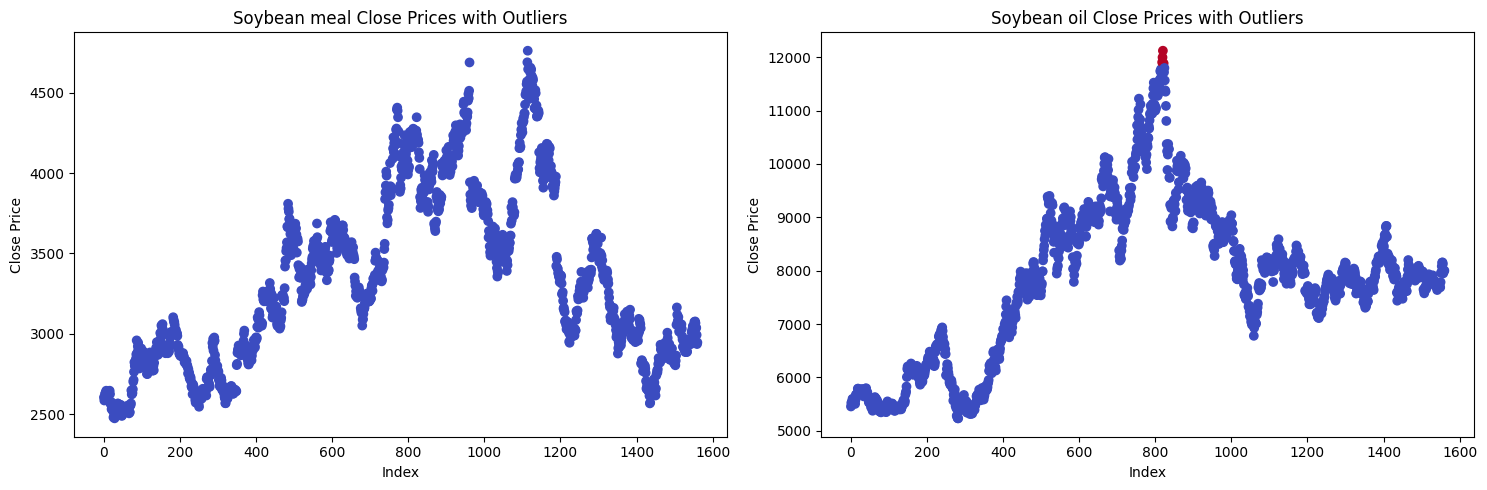

In [11]:
import matplotlib.pyplot as plt

# Set Graphics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot the outliers of df_meal
ax1.scatter(df_meal.index, df_meal['Close'], c=df_meal['outlier_iqr'], cmap='coolwarm')
ax1.set_title('Soybean meal Close Prices with Outliers')
ax1.set_xlabel('Index')
ax1.set_ylabel('Close Price')

# Plot the outliers of df_oil
ax2.scatter(df_oil.index, df_oil['Close'], c=df_oil['outlier_iqr'], cmap='coolwarm')
ax2.set_title('Soybean oil Close Prices with Outliers')
ax2.set_xlabel('Index')
ax2.set_ylabel('Close Price')

plt.tight_layout()
plt.show()

## Diagnostic Summary
- No drastic change in data within one contract
- The diagnostic report using IQR method can not clearly demonstrate the **exact outliers** of data in a time-series
- The original data fits the daily trading data well showing enough consistency. No need to winsorize or drop the outliers.

## Statistical Summary

In [12]:
# Statistical function, excluding non-numeric columns
def summarize(df, name):
    df_numeric = df.select_dtypes(include="number")  # Only retain numeric columns
    summary = pd.DataFrame({
        "mean": df_numeric.mean(),
        "median": df_numeric.median(),
        "std": df_numeric.std(),
        "min": df_numeric.min(),
        "max": df_numeric.max(),
        "missing": df_numeric.isnull().sum(),
        "skewness": df_numeric.skew()
    })
    summary["dataset"] = name
    return summary

# Separate Statistics
summary_meal = summarize(df_meal, "Meal")
summary_oil = summarize(df_oil, "Oil")

# Merge together
summary_compare = pd.concat([summary_meal, summary_oil])

# PivotTable Comparison
summary_pivot = summary_compare.reset_index().pivot(
    index="index", columns="dataset", values=["mean","median","std","min","max","missing","skewness"])

# Formatted Output
pd.set_option("display.float_format", lambda x: f"{x:.3f}")
summary_pivot

mean            median              std               min  \
dataset     Meal      Oil     Meal      Oil    Meal      Oil     Meal   
index                                                                   
Close   3326.347 7807.639 3248.000 7872.000 531.225 1465.594 2474.000   
High    3354.375 7883.277 3273.000 7940.000 538.335 1492.936 2016.000   
Low     3295.462 7727.621 3220.000 7806.000 522.008 1437.256 2381.000   
Open    3325.541 7804.883 3250.000 7872.000 528.359 1465.790 2475.000   

                      max           missing       skewness        
dataset      Oil     Meal       Oil    Meal   Oil     Meal   Oil  
index                                                             
Close   5234.000 4761.000 12122.000   0.000 0.000    0.461 0.135  
High    5270.000 4771.000 12280.000   0.000 0.000    0.449 0.145  
Low     5114.000 4665.000 11952.000   0.000 0.000    0.464 0.132  
Open    5190.000 4665.000 12176.000   0.000 0.000    0.456 0.139

# Technical Indicator Calculation and Visualization
## 1. Technical Indicator Calculation
### Indicators
- **Moving Averages**:
  - MA5: 5-day simple moving average
  - MA20: 20-day simple moving average
  - MA60: 60-day simple moving average
- **Exponential Moving Averages**:
  - EMA3: 12-period EMA (mislabeled as EMA3)
  - EMA10: 26-period EMA (mislabeled as EMA10)
- **MACD Components**:
  - MACD Line: Difference between EMA3 and EMA10 (12-period and 26-period EMAs)
  - Signal Line: 9-period EMA of the MACD line
  - MACD Histogram: Difference between MACD and Signal lines

## 2. Visualization of Technical Indicators
### Price Chart with Moving Averages
- Identical structure to soybean meal price chart
- Shows soybean oil price with 20-day and 60-day moving averages

### MACD Chart
- Identical structure to soybean meal MACD chart
- Shows soybean oil MACD components

## Technical Note
There appears to be a labeling inconsistency in the code:
- The variables are named `EMA3` and `EMA10` but are calculated using spans of 12 and 26 respectively
- This suggests either a mislabeling or an error in parameter selection
- Standard MACD calculation uses 12-period and 26-period EMAs

## Purpose
This code implements a comprehensive technical analysis framework for:
- Calculating multiple trend-following indicators (moving averages)
- Generating momentum indicators (MACD and its components)
- Visualizing price action alongside technical indicators
- Facilitating comparative analysis between soybean meal and soybean oil

The resulting charts provide traders with visual signals for potential:
- Trend identification (using moving averages)
- Momentum shifts (using MACD crossovers)
- Entry/exit points (using MACD histogram patterns)

## Moving Average of Price

In [13]:
# Calculate the technical indicators of soybean meal
short_window = 12  
long_window = 26  
signal_window = 9  

last_year_meal['MA5'] = last_year_meal['Close'].rolling(window=5).mean()
last_year_meal['MA20'] = last_year_meal['Close'].rolling(window=20).mean()
last_year_meal['MA60'] = last_year_meal['Close'].rolling(window=60).mean()
last_year_meal['EMA3'] = last_year_meal['Close'].ewm(span=short_window, adjust=False).mean()
last_year_meal['EMA10'] = last_year_meal['Close'].ewm(span=long_window, adjust=False).mean()
last_year_meal['MACD'] = last_year_meal['EMA3'] - last_year_meal['EMA10']
last_year_meal['Signal'] = last_year_meal['MACD'].ewm(span=signal_window, adjust=False).mean()
last_year_meal['MACD_Hist'] = last_year_meal['MACD'] - last_year_meal['Signal']

# Calculate the technical indicators of soybean oil
last_year_oil['MA5'] = last_year_oil['Close'].rolling(window=5).mean()
last_year_oil['MA20'] = last_year_oil['Close'].rolling(window=20).mean()
last_year_oil['MA60'] = last_year_oil['Close'].rolling(window=60).mean()
last_year_oil['EMA3'] = last_year_oil['Close'].ewm(span=short_window, adjust=False).mean()
last_year_oil['EMA10'] = last_year_oil['Close'].ewm(span=long_window, adjust=False).mean()
last_year_oil['MACD'] = last_year_oil['EMA3'] - last_year_oil['EMA10']
last_year_oil['Signal'] = last_year_oil['MACD'].ewm(span=signal_window, adjust=False).mean()
last_year_oil['MACD_Hist'] = last_year_oil['MACD'] - last_year_oil['Signal']

## Price curve of soybean meal and soybean oil & MACD curves (Time Series)

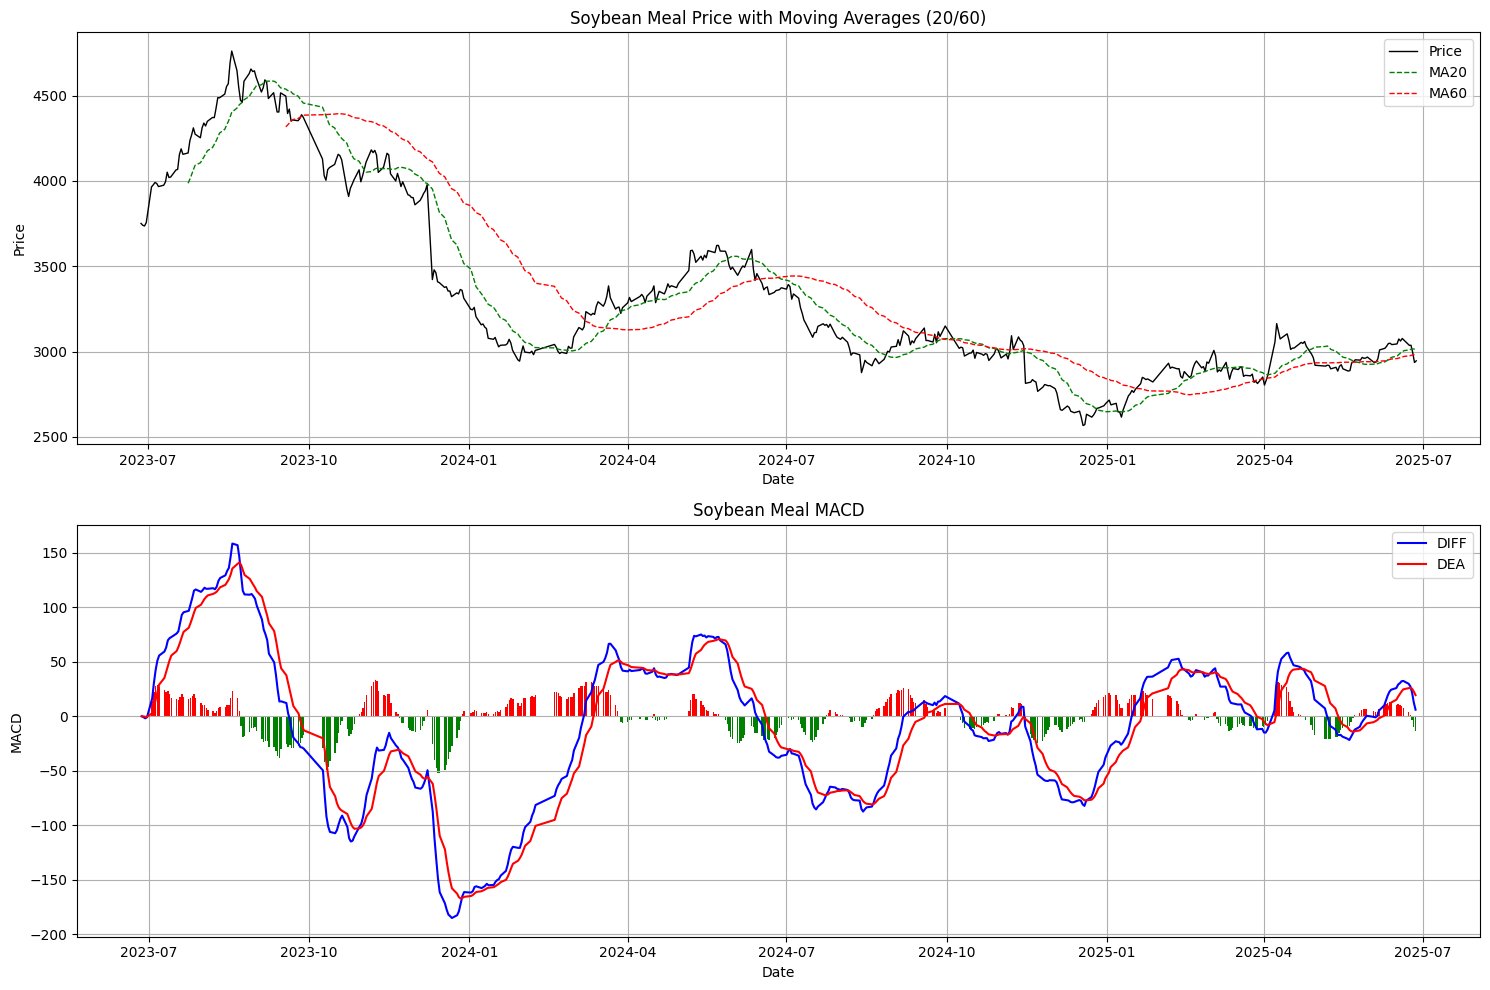

In [14]:
# Draw a chart of soybean meal
plt.figure(figsize=(15, 10))
# Soybean Meal Price chart
ax1 = plt.subplot(2, 1, 1)
ax1.plot(last_year_meal['Date'], last_year_meal['Close'], label='Price', color='black', linewidth=1)
ax1.plot(last_year_meal['Date'], last_year_meal['MA20'], label='MA20', color='green', linestyle='--', linewidth=1)
ax1.plot(last_year_meal['Date'], last_year_meal['MA60'], label='MA60', color='red', linestyle='--', linewidth=1)
ax1.set_title('Soybean Meal Price with Moving Averages (20/60)', fontsize=12)
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True)

# MACD Chart of Soybean meal
ax2 = plt.subplot(2, 1, 2)
colors = ['red' if val > 0 else 'green' for val in last_year_meal['MACD_Hist']]
ax2.bar(last_year_meal['Date'], last_year_meal['MACD_Hist'], color=colors)
ax2.plot(last_year_meal['Date'], last_year_meal['MACD'], color='blue', label='DIFF')
ax2.plot(last_year_meal['Date'], last_year_meal['Signal'], color='red', label='DEA')
ax2.set_title('Soybean Meal MACD', fontsize=12)
ax2.set_xlabel('Date')
ax2.set_ylabel('MACD')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

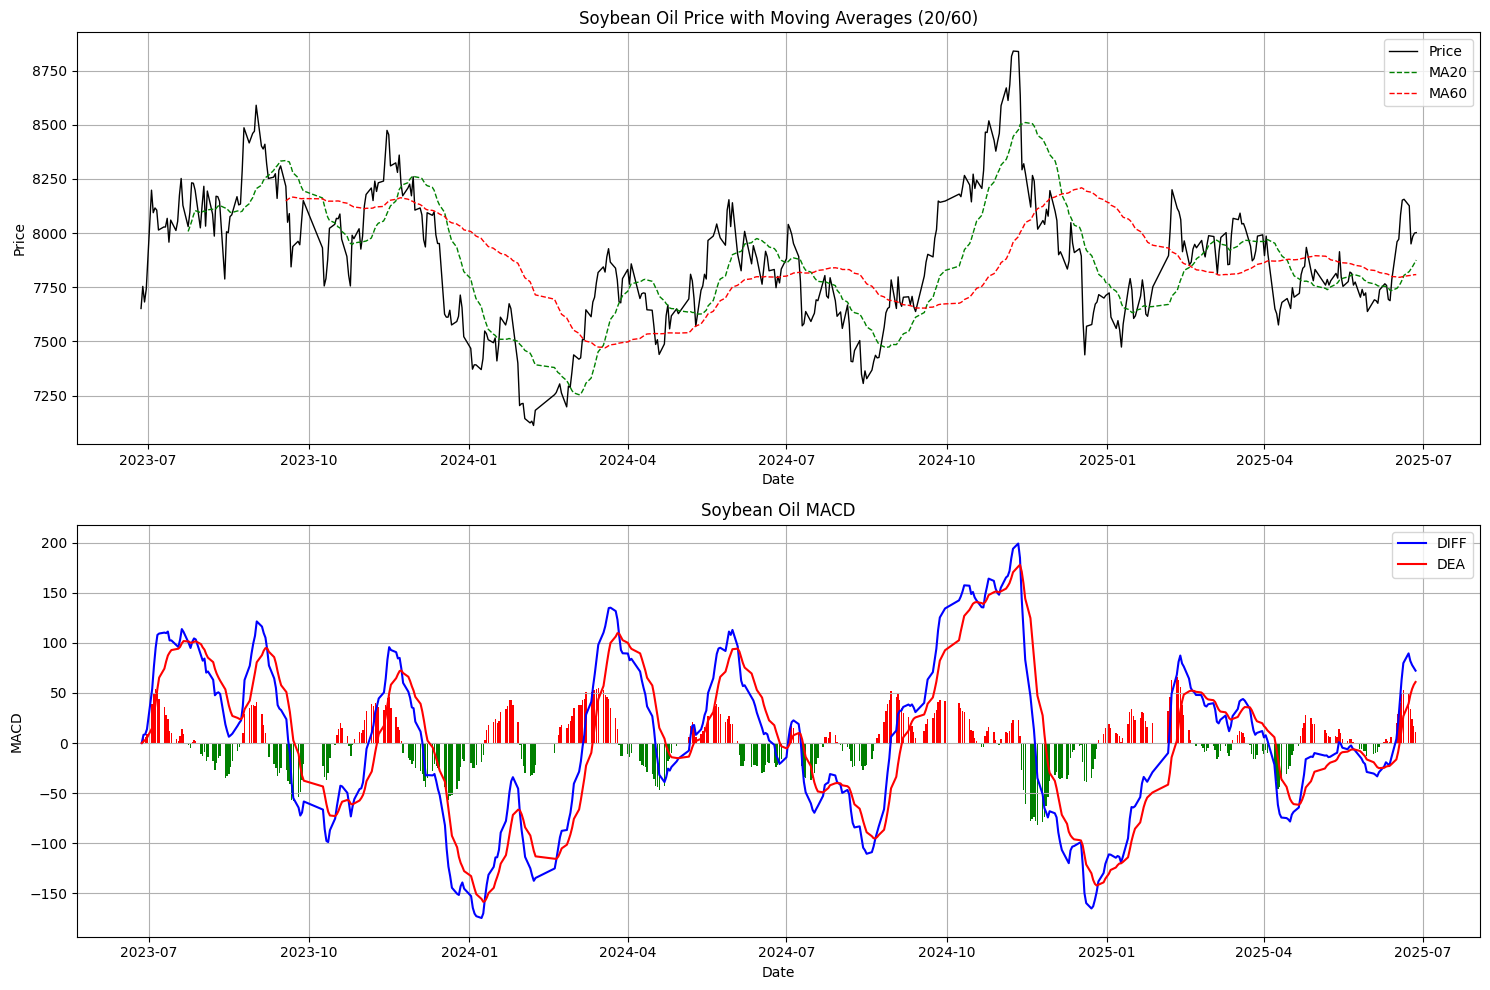

In [15]:
# Draw a chart of Soybean oil
plt.figure(figsize=(15, 10))
# Soybean Oil Price chart
ax1 = plt.subplot(2, 1, 1)
ax1.plot(last_year_oil['Date'], last_year_oil['Close'], label='Price', color='black', linewidth=1)
ax1.plot(last_year_oil['Date'], last_year_oil['MA20'], label='MA20', color='green', linestyle='--', linewidth=1)
ax1.plot(last_year_oil['Date'], last_year_oil['MA60'], label='MA60', color='red', linestyle='--', linewidth=1)
ax1.set_title('Soybean Oil Price with Moving Averages (20/60)', fontsize=12)
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True)

# Soybean Oil MACD chart
ax2 = plt.subplot(2, 1, 2)
colors = ['red' if val > 0 else 'green' for val in last_year_oil['MACD_Hist']]
ax2.bar(last_year_oil['Date'], last_year_oil['MACD_Hist'], color=colors)
ax2.plot(last_year_oil['Date'], last_year_oil['MACD'], color='blue', label='DIFF')
ax2.plot(last_year_oil['Date'], last_year_oil['Signal'], color='red', label='DEA')
ax2.set_title('Soybean Oil MACD', fontsize=12)
ax2.set_xlabel('Date')
ax2.set_ylabel('MACD')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# MACD peak and trough Indicator 
# (Why I choose this feature in constructing my trading strategy)
## 1. Trend Information
- When **MACD > 0**, the short-term moving average is above the long-term moving average, indicating an upward price tendency.  
- When **MACD < 0**, the short-term moving average is below the long-term moving average, indicating a downward price tendency.  

## 2. Momentum Changes
- The **MACD histogram** (difference between MACD and the signal line) measures the strength or weakness of momentum.  
- When the histogram changes from positive to negative, it often signals a potential trend reversal in price.  

## 3. Peak-Trough Features and Price Reversals
- Local **peaks of the MACD** correspond to momentum tops during upward price movements.  
- Local **troughs of the MACD** correspond to momentum bottoms during downward price movements.  
- This shows that the extreme points (highs/lows) of MACD are often highly correlated with the peaks/troughs of price, albeit with a certain time lag. 

## MACD Construction and Energy Histogram tracking

In [16]:


def is_histogram_growing(data, current_index):
    """
    Determine whether the MACD energy bar shows a growth trend (with the absolute value increasing)
    """
    if current_index < 1 or current_index >= len(data):
        return False
    
    current_hist = data['MACD_Hist'].iloc[current_index]
    prev_hist = data['MACD_Hist'].iloc[current_index - 1]
    
    # Determine whether the absolute value of the energy column is increasing
    return abs(current_hist) > abs(prev_hist)

def find_previous_peak(data, current_index):
    """
    Find the most recent peak before the current position
    Return the absolute value of the wave peak. If not found, return None
    """
    for i in range(current_index - 1, 1, -1):
        hist_prev = abs(data['MACD_Hist'].iloc[i - 1])
        hist_curr = abs(data['MACD_Hist'].iloc[i])
        hist_next = abs(data['MACD_Hist'].iloc[i + 1])
        
        if hist_curr > hist_prev and hist_curr > hist_next:
            return hist_curr
    return None

def is_histogram_peak(data, current_index):
    """
    Determine whether the current position is the peak of the MACD energy column (with the largest absolute value)
    """
    if current_index < 2 or current_index >= len(data) - 1:
        return False
        
    hist_prev = abs(data['MACD_Hist'].iloc[current_index - 1])
    hist_curr = abs(data['MACD_Hist'].iloc[current_index])
    hist_next = abs(data['MACD_Hist'].iloc[current_index + 1])
    
    # Determine if it is a wave peak (the absolute value of the current column is greater than that of the previous and next columns)
    is_peak = hist_curr > hist_prev and hist_curr > hist_next
    
    # New condition: The length difference from the next energy column must be greater than 1; otherwise, it will be regarded as a continuous peak
    if is_peak:
        diff_with_next = hist_curr - hist_next
        if diff_with_next <= 1:
            return False
    
    return is_peak

## Trend tracking and monitoring

In [17]:
def determine_trend(data, index):
    """
    Judge the trend
    1. Judge the trend through the positional relationship between the 5-day moving average and the 20-day moving average
    2. Return: 1 indicates an upward trend, -1 indicates a downward trend, and 0 indicates no clear trend
    """
    if index < 20:  # Make sure there is sufficient data to calculate the moving average
        return 0
        
    ma5 = data['MA5'].iloc[index]
    ma20 = data['MA20'].iloc[index]
    
    if ma5 > ma20:
        return 1  # Upward Trend
    elif ma5 < ma20:
        return -1  # Downward Trend
    return 0  # No clear trend

def is_histogram_trough(data, index):
    """
    Determine whether the current position is the trough of the MACD energy column (the absolute value trough)
    Condition
    1. The absolute value of the energy column on that day is less than that of the previous day and the day after
    2. The absolute value of the energy column on that day must be less than 20
    Return: True indicates a trough, False indicates not a trough
    """
    if index < 1 or index >= len(data) - 1:
        return False
        
    hist_prev = abs(data['MACD_Hist'].iloc[index - 1])
    hist_curr = abs(data['MACD_Hist'].iloc[index])
    hist_next = abs(data['MACD_Hist'].iloc[index + 1])
    
    # The absolute value of the energy column on the current day is less than that of the previous day and the day after, and the absolute value is less than 20
    return hist_curr < hist_prev and hist_curr < hist_next and hist_curr < 20

# Deep learning model application in extracting time features
## 1. Dataset Partitioning
- Use the time series partitioning method (** The last 250 days as the test set, and the rest as the training set **)
- No random division is made

## 2. Feature scaling + Sliding window
- Use 'MinMaxScaler' to scale the price to [0,1]
- Build a sliding window of length 10 to form a supervised learning sample '(X, y)'
- Construct the training set and the test set respectively
- The shape of the output data

## 3. Define deep learning models
- **LSTM Model** : Capture the long-term dependencies of time series
- **CNN+LSTM Model** : First, local features are extracted using convolution, and then sequence dependencies are captured using LSTM
- **CNN+Transformer Model** : CNN extracts features, and Transformer captures global dependencies
- **CNN+LSTM+Transformer Model** : Combining the advantages of the three

## 4. Model Training
- Train four models respectively (LSTM, CNN+LSTM, CNN+Transformer, CNN+LSTM+Transformer)
- Use EarlyStopping to prevent overfitting
- Each model is trained for 150 epochs, with batch_size = 16

## 5. Model Evaluation
### Evaluate each model on the test set:
- **Loss**
- **MAPE** (Mean Absolute Percentage Error)
- **Accuracy (1 - MAPE)**
### Visual comparison
- The true value of the training set
- True values of the test set
- Test set prediction values

## 6. Future Price Forecast and Visualizing
- Define the 'predict_future_prices' function
- Use the last sliding window to predict the price for the next 10 days
- Output the future prediction results of the four models respectively
- Draw the predicted price trend for the next 10 days
- Compare the prediction curves of CNN+LSTM, CNN+Transformer, and CNN+LSTM+Transformer

## Split the data into a training set and a testing set

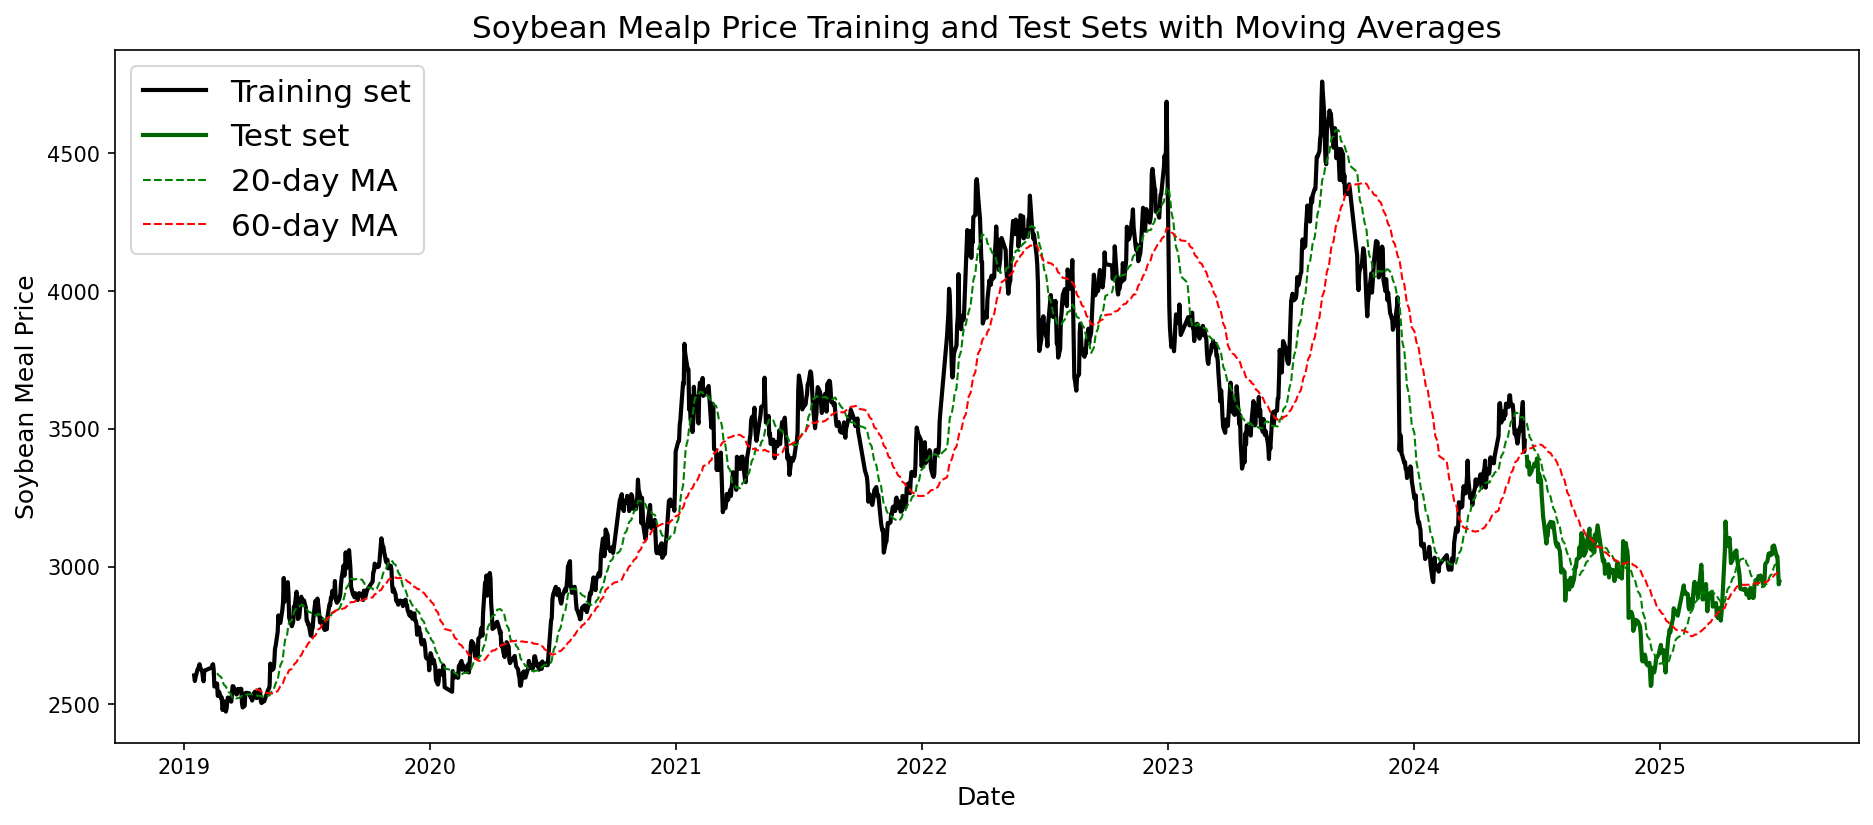

In [16]:
test_size = 250
train_data = df_meal.iloc[:-test_size]
test_data = df_meal.iloc[-test_size:]

# Calculate the 5-day moving average, 20-day moving average and 60-day moving average
df_meal['MA5'] = df_meal['Close'].rolling(window=5).mean()
df_meal['MA20'] = df_meal['Close'].rolling(window=20).mean()
df_meal['MA60'] = df_meal['Close'].rolling(window=60).mean()

# Visualized soybean meal price training and test set as well as moving averages
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes', edgecolor='black')
plt.plot(train_data.Date, train_data.Close, color='black', lw=2, label='Training set')
plt.plot(test_data.Date, test_data.Close, color='darkgreen', lw=2, label='Test set')
plt.plot(df_meal['Date'], df_meal['MA20'], color='green', lw=1, linestyle='--', label='20-day MA')
plt.plot(df_meal['Date'], df_meal['MA60'], color='red', lw=1, linestyle='--', label='60-day MA')
plt.title('Soybean Mealp Price Training and Test Sets with Moving Averages', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Soybean Meal Price', fontsize=12)
plt.legend(loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

# Data Scaling
scaler = MinMaxScaler()
scaler.fit(df_meal.Close.values.reshape(-1, 1))

# Reconstruct the data and create a sliding window
window_size = 10

# Training Set:
train_data_scaled = scaler.transform(train_data.Close.values.reshape(-1, 1))
X_train = []
y_train = []

for i in range(window_size, len(train_data_scaled)):
    X_train.append(train_data_scaled[i - window_size:i, 0])
    y_train.append(train_data_scaled[i, 0])

# Test Set:
test_data_scaled = scaler.transform(test_data.Close.values.reshape(-1, 1))
X_test = []
y_test = []

# Ensure that the test set has enough data points to create a sliding window
if len(test_data_scaled) >= window_size:
    for i in range(window_size, len(test_data_scaled)):
        X_test.append(test_data_scaled[i - window_size:i, 0])
        y_test.append(test_data_scaled[i, 0])
else:
    print("The test set data is insufficient to create a sliding window")

# Convert data to a Numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)

if len(X_train) > 0:
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_train = np.reshape(y_train, (-1, 1))

if len(X_test) > 0:
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    y_test = np.reshape(y_test, (-1, 1))

## Define the CNN, LSTM, Transformer models
### Combining CNN, LSTM and Transformer can leverage the advantages of each model to handle complex sequence data.
- CNN: It is used for extracting local features and is particularly suitable for processing local patterns in images or time series.
- LSTM: It is used to capture long-term dependencies and is suitable for handling time series data.
- Transformer: It is used to capture global dependencies, especially through the self-attention mechanism, and can process sequential data in parallel.

In [19]:
# Define the Transformer block
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# The structure of the combined model

#CNN Layer: Firstly, a convolutional layer is used to extract local features.
#LSTM Layer: Then use the LSTM layer to capture long-term dependencies.
#Transformer Layer: Finally, use the Transformer layer to capture global dependencies.

# Define LSTM models
def define_lstm_model(window_size):
    inputs = Input(shape=(window_size, 1))
    
    # LSTM layer
    x = LSTM(units=128, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(units=128, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units=128)(x)
    x = Dropout(0.2)(x)
    
    # Fully connected Layer
    x = Dense(16, activation='relu')(x)
    output = Dense(1)(x)

    model = Model(inputs=inputs, outputs=output)
    
    # Adjust the learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mean_squared_error")
    model.summary()

    return model

# Define the CNN+LSTM model
def define_cnn_lstm_model(window_size):
    inputs = Input(shape=(window_size, 1))
    
    # CNN Layer
    x = Conv1D(filters=128, kernel_size=3, padding="causal", activation="relu")(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    # LSTM Layer
    x = LSTM(units=128, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units=128)(x)
    x = Dropout(0.2)(x)
    
    # Fully connected Layer
    x = Dense(16, activation='relu')(x)
    output = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=output)
    
    # Adjust the learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mean_squared_error")
    model.summary()
    
    return model

# Define the CNN+Transformer Model
def define_cnn_transformer_model(window_size, embed_dim, num_heads, ff_dim):
    inputs = Input(shape=(window_size, 1))
    
    # CNN Layer
    x = Conv1D(filters=128, kernel_size=3, padding="causal", activation="relu")(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)  
    x = Conv1D(filters=128, kernel_size=3, padding="causal", activation="relu")(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)  
     
    x = tf.keras.layers.Reshape((x.shape[1], 128))(x)    
    x = tf.keras.layers.TimeDistributed(Dense(embed_dim))(x)
    
    # Transformer block
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x, training=True)
    x = GlobalAveragePooling1D()(x)
    x = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=x)
    
    # Adjust the learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="mean_squared_error")
    model.summary()
    
    return model

# Define the CNN+LSTM+Transformer model
def define_cnn_lstm_transformer_model(window_size, embed_dim, num_heads, ff_dim):
    inputs = Input(shape=(window_size, 1))
    
    # CNN Layer
    x = Conv1D(filters=128, kernel_size=3, padding="causal", activation="relu")(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = Conv1D(filters=128, kernel_size=3, padding="causal", activation="relu")(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    # LSTM Layer
    x = LSTM(units=128, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units=128)(x)
    x = Dropout(0.2)(x)

    x = tf.keras.layers.Reshape((1, 128))(x)    
    x = tf.keras.layers.TimeDistributed(Dense(embed_dim))(x)
    
    # Transformer block  
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x, training=True)
    x = GlobalAveragePooling1D()(x)
    x = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=x)
    
    # Adjust the learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="mean_squared_error")
    model.summary()
    
    return model

# Define and Train LSTM models
lstm_model = define_lstm_model(window_size)

if len(X_train) > 0:
    print("Start training the LSTM model...")
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Use the early stop method
    history_lstm = lstm_model.fit(X_train, y_train, epochs=150, batch_size=16, validation_split=0.1, verbose=1, callbacks=[early_stopping])  # Adjust the number of training rounds and batch size
else:
    print("The training data is insufficient to train the LSTM model")
    
# Define and Train CNN+LSTM model
cnn_lstm_model = define_cnn_lstm_model(window_size)

if len(X_train) > 0:
    print("Start training the CNN+LSTM model...")
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history_cnn_lstm = cnn_lstm_model.fit(X_train, y_train, epochs=150, batch_size=16, validation_split=0.1, verbose=1, callbacks=[early_stopping])
else:
    print("The training data is insufficient to train the CNN+LSTM model")

# Define and Train CNN+Transformer model
cnn_transformer_model = define_cnn_transformer_model(window_size, embed_dim=64, num_heads=4, ff_dim=64)  

if len(X_train) > 0:
    print("Start training the CNN+Transformer model...")
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Use the early stop method
    history_cnn_transformer = cnn_transformer_model.fit(X_train, y_train, epochs=150, batch_size=16, validation_split=0.1, verbose=1, callbacks=[early_stopping])  # Adjust the number of training rounds and batch size
else:
    print("The training data is insufficient to train the CNN+Transformer model")
    
# Define and Train CNN+LSTM+Transformer model
cnn_lstm_transformer_model = define_cnn_lstm_transformer_model(window_size, embed_dim=64, num_heads=4, ff_dim=64)

if len(X_train) > 0:
    print("Start training the CNN+LSTM+Transformer model...")
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history_cnn_lstm_transformer = cnn_lstm_transformer_model.fit(X_train, y_train, epochs=150, batch_size=16, validation_split=0.1, verbose=1, callbacks=[early_stopping])
else:
    print("The training data is insufficient to train the CNN+LSTM+Transformer model")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 331,809 (1.27 MB)

 Trainable params: 331,809 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Start training the LSTM model...
Epoch 1/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0170 - val_loss: 0.0061
Epoch 2/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 3/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0036 - val_loss: 0.0053
Epoch 4/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 5/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 6/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 7/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 8/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 9/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 10/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 11/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 12/150
74/74 

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 5, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 265,761 (1.01 MB)

 Trainable params: 265,761 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

Start training the CNN+LSTM model...
Epoch 1/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0192 - val_loss: 0.0048
Epoch 2/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 3/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 4/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 5/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 6/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 7/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 8/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0071
Epoch 9/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 11/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 12/150
74/74 ━━━━━━━

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 5, 128)         │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 2, 64)          │         8,256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 2, 64)          │        74,944 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,057 (519.75 KB)

 Trainable params: 133,057 (519.75 KB)

 Non-trainable params: 0 (0.00 B)

Start training the CNN+Transformer model...
Epoch 1/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.2189 - val_loss: 0.0367
Epoch 2/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0470 - val_loss: 0.0125
Epoch 3/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0354 - val_loss: 0.0040
Epoch 4/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0284 - val_loss: 0.0039
Epoch 5/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0233 - val_loss: 0.0090
Epoch 6/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0223 - val_loss: 0.0047
Epoch 7/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0171 - val_loss: 0.0116
Epoch 8/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0172 - val_loss: 0.0056
Epoch 9/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0138 - val_loss: 0.0050
Epoch 10/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0135 - val_loss: 0.0205
Epoch 11/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0155 - val_loss: 0.0085
Epoch 12/150
74/74 

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 5, 128)         │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 2, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 1, 64)          │         8,256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 1, 64)          │        74,944 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 396,225 (1.51 MB)

 Trainable params: 396,225 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

Start training the CNN+LSTM+Transformer model...
Epoch 1/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 1.0134 - val_loss: 0.0084
Epoch 2/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1062 - val_loss: 0.0086
Epoch 3/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0796 - val_loss: 0.0145
Epoch 4/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0611 - val_loss: 0.0040
Epoch 5/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0440 - val_loss: 0.0098
Epoch 6/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0373 - val_loss: 0.0076
Epoch 7/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0323 - val_loss: 0.0112
Epoch 8/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0289 - val_loss: 0.0042
Epoch 9/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0259 - val_loss: 0.0039
Epoch 10/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0223 - val_loss: 0.0048
Epoch 11/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0181 - val_loss: 0.0050
Epoch 12/150


## Model Evaluation
### 1. Loss
- **Definition**:  
  The loss function measures the average difference between predicted values and actual values, based on the optimization objective defined during training (e.g., Mean Squared Error, Mean Absolute Error).

- **Purpose**:  
  - Provides a mathematical standard that the model directly minimizes during training.  
  - Lower loss indicates better alignment with the training objective.  

- **Reason for use**:  
  It is the most direct and consistent indicator of how well the model fits the data.

### 2. MAPE (Mean Absolute Percentage Error)
- **Definition**:  
  MAPE measures the average absolute percentage difference between actual values and predicted values.  

- **Purpose**:  
  - Expresses error as a percentage, making results more interpretable.  
  - Example: MAPE = 0.05 means predictions are on average within 5% of the actual values.  

- **Reason for use**:  
  Useful for business and financial applications where stakeholders need relative error rather than absolute error.

### 3. Accuracy (based on MAPE)
- **Definition**:  
  In regression tasks, accuracy can be defined as:  

- **Purpose**:  
  - Translates error into an intuitive “accuracy” score (e.g., 95% accuracy if MAPE = 0.05).  
  - Easier for non-technical stakeholders to understand.  

- **Reason for use**:  
  Regression tasks do not have traditional classification-style accuracy. This metric provides a positive, intuitive interpretation of prediction quality.

In [20]:
# Model Evaluation
# Evaluate LSTM models
result_lstm = lstm_model.evaluate(X_test, y_test)
y_pred_lstm = lstm_model.predict(X_test)

# Convert y_test and y_pred_lstm to two-dimensional arrays
y_test_2d = y_test.reshape(-1, 1)
y_pred_lstm_2d = y_pred_lstm.reshape(-1, 1)

# Ensure that the lengths of y_test_2d and y_pred_lstm_2d are the same
min_len = min(len(y_test_2d), len(y_pred_lstm_2d))
y_test_2d = y_test_2d[:min_len]
y_pred_lstm_2d = y_pred_lstm_2d[:min_len]

MAPE_lstm = mean_absolute_percentage_error(y_test_2d, y_pred_lstm_2d)
Accuracy_lstm = 1 - MAPE_lstm

print("LSTM Test Loss:", result_lstm)
print("LSTM Test MAPE:", MAPE_lstm)
print("LSTM Test Accuracy:", Accuracy_lstm)
    
# Evaluation of CNN+LSTM Models
result_cnn_lstm = cnn_lstm_model.evaluate(X_test, y_test)
y_pred_cnn_lstm = cnn_lstm_model.predict(X_test)

# Convert y_test and y_pred_cnn_lstm to two-dimensional arrays
y_pred_cnn_lstm_2d = y_pred_cnn_lstm.reshape(-1, 1)

# Ensure that the lengths of y_test_2d and y_pred_cnn_lstm_2d are the same
min_len = min(len(y_test_2d), len(y_pred_cnn_lstm_2d))
y_test_2d = y_test_2d[:min_len]
y_pred_cnn_lstm_2d = y_pred_cnn_lstm_2d[:min_len]

MAPE_cnn_lstm = mean_absolute_percentage_error(y_test_2d, y_pred_cnn_lstm_2d)
Accuracy_cnn_lstm = 1 - MAPE_cnn_lstm

print("CNN+LSTM Test Loss:", result_cnn_lstm)
print("CNN+LSTM Test MAPE:", MAPE_cnn_lstm)
print("CNN+LSTM Test Accuracy:", Accuracy_cnn_lstm)

# Evaluation of CNN+Transformer Models
result_cnn_transformer = cnn_transformer_model.evaluate(X_test, y_test)
y_pred_cnn_transformer = cnn_transformer_model.predict(X_test)

# Convert y_test and y_pred_cnn_transformer into two-dimensional arrays
y_pred_cnn_transformer_2d = y_pred_cnn_transformer.reshape(-1, 1)

# Ensure that the lengths of y_test_2d and y_pred_cnn_transformer_2d are the same
min_len = min(len(y_test_2d), len(y_pred_cnn_transformer_2d))
y_test_2d = y_test_2d[:min_len]
y_pred_cnn_transformer_2d = y_pred_cnn_transformer_2d[:min_len]

MAPE_cnn_transformer = mean_absolute_percentage_error(y_test_2d, y_pred_cnn_transformer_2d)
Accuracy_cnn_transformer = 1 - MAPE_cnn_transformer

print("CNN+Transformer Test Loss:", result_cnn_transformer)
print("CNN+Transformer Test MAPE:", MAPE_cnn_transformer)
print("CNN+Transformer Test Accuracy:", Accuracy_cnn_transformer)
    
# Evaluation of CNN+LSTM+Transformer Models
result_cnn_lstm_transformer = cnn_lstm_transformer_model.evaluate(X_test, y_test)
y_pred_cnn_lstm_transformer = cnn_lstm_transformer_model.predict(X_test)

# Convert y_test and y_pred_cnn_lstm_transformer into two-dimensional arrays
y_pred_cnn_lstm_transformer_2d = y_pred_cnn_lstm_transformer.reshape(-1, 1)

# Ensure that the lengths of y_test_2d and y_pred_cnn_lstm_transformer_2d are the same
min_len = min(len(y_test_2d), len(y_pred_cnn_lstm_transformer_2d))
y_test_2d = y_test_2d[:min_len]
y_pred_cnn_lstm_transformer_2d = y_pred_cnn_lstm_transformer_2d[:min_len]

MAPE_cnn_lstm_transformer = mean_absolute_percentage_error(y_test_2d, y_pred_cnn_lstm_transformer_2d)
Accuracy_cnn_lstm_transformer = 1 - MAPE_cnn_lstm_transformer

print("CNN+LSTM+Transformer Test Loss:", result_cnn_lstm_transformer)
print("CNN+LSTM+Transformer Test MAPE:", MAPE_cnn_lstm_transformer)
print("CNN+LSTM+Transformer Test Accuracy:", Accuracy_cnn_lstm_transformer)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.3195e-04 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
LSTM Test Loss: 0.00033195328433066607
LSTM Test MAPE: 0.07129141786114174
LSTM Test Accuracy: 0.9287085821388583
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0228e-04 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
CNN+LSTM Test Loss: 0.0004022842040285468
CNN+LSTM Test MAPE: 0.0820969422488034
CNN+LSTM Test Accuracy: 0.9179030577511966
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
CNN+Transformer Test Loss: 0.0034079730976372957
CNN+Transformer Test MAPE: 0.2575850462650714
CNN+Transformer Test Accuracy: 0.7424149537349286
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
CNN+LSTM+Transformer Test Loss: 0.001848185551352799
CNN+LSTM+Transformer Test MAPE: 0.19364183659395037
CNN+LSTM+Transformer Test Accuracy: 0.8063581634060496


## Model Visualization

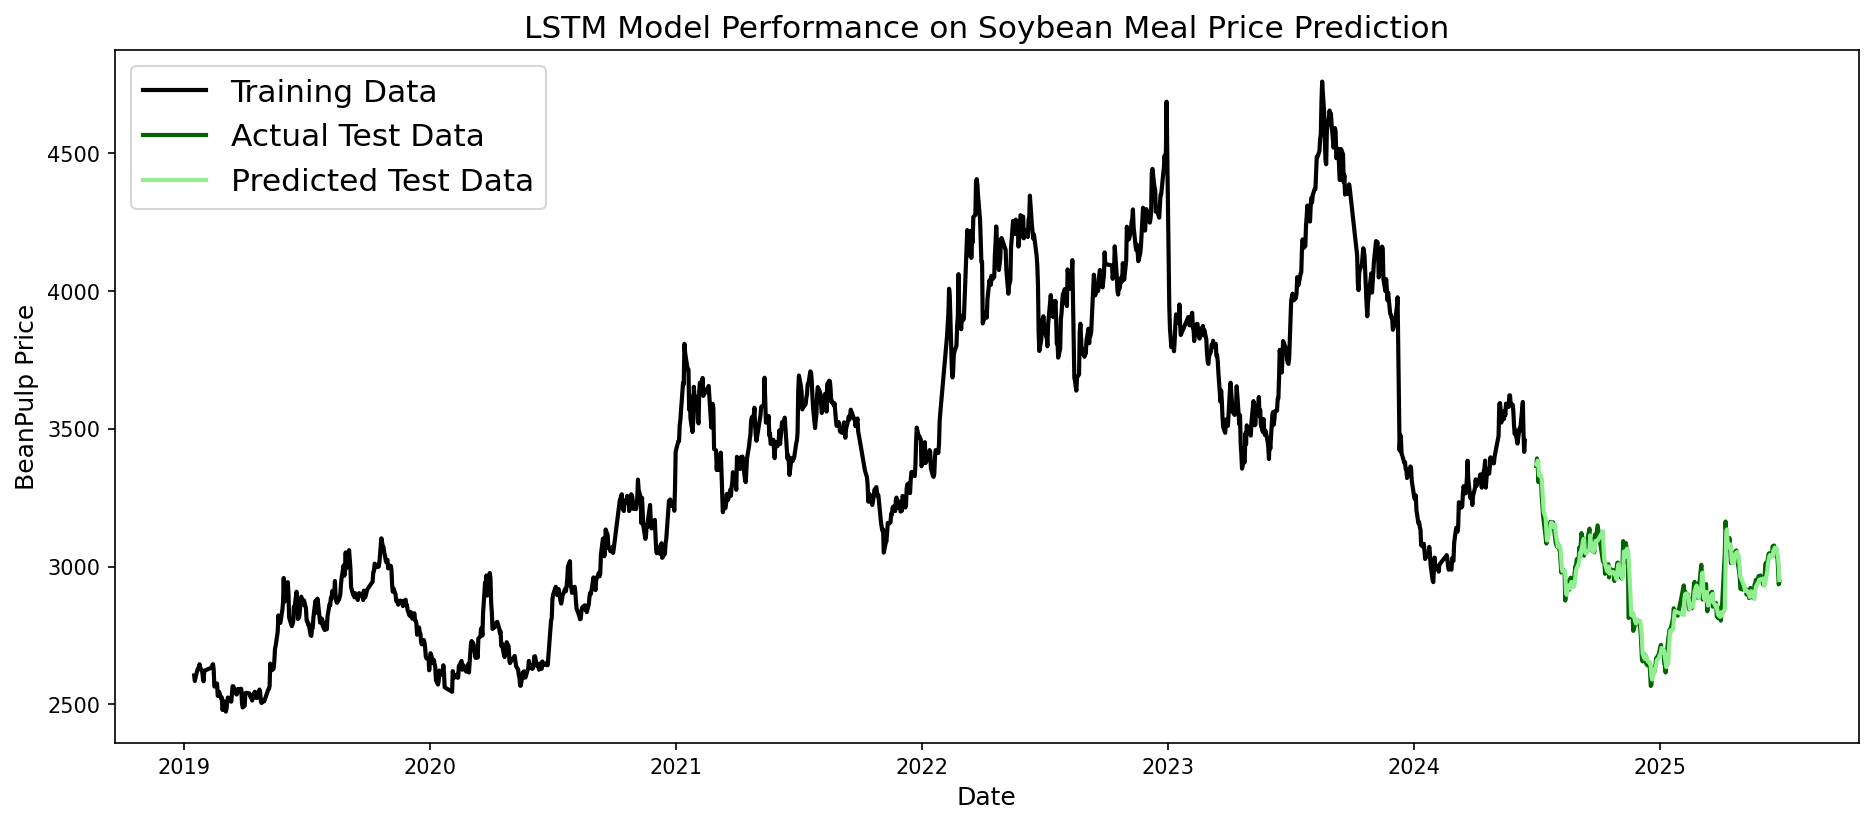

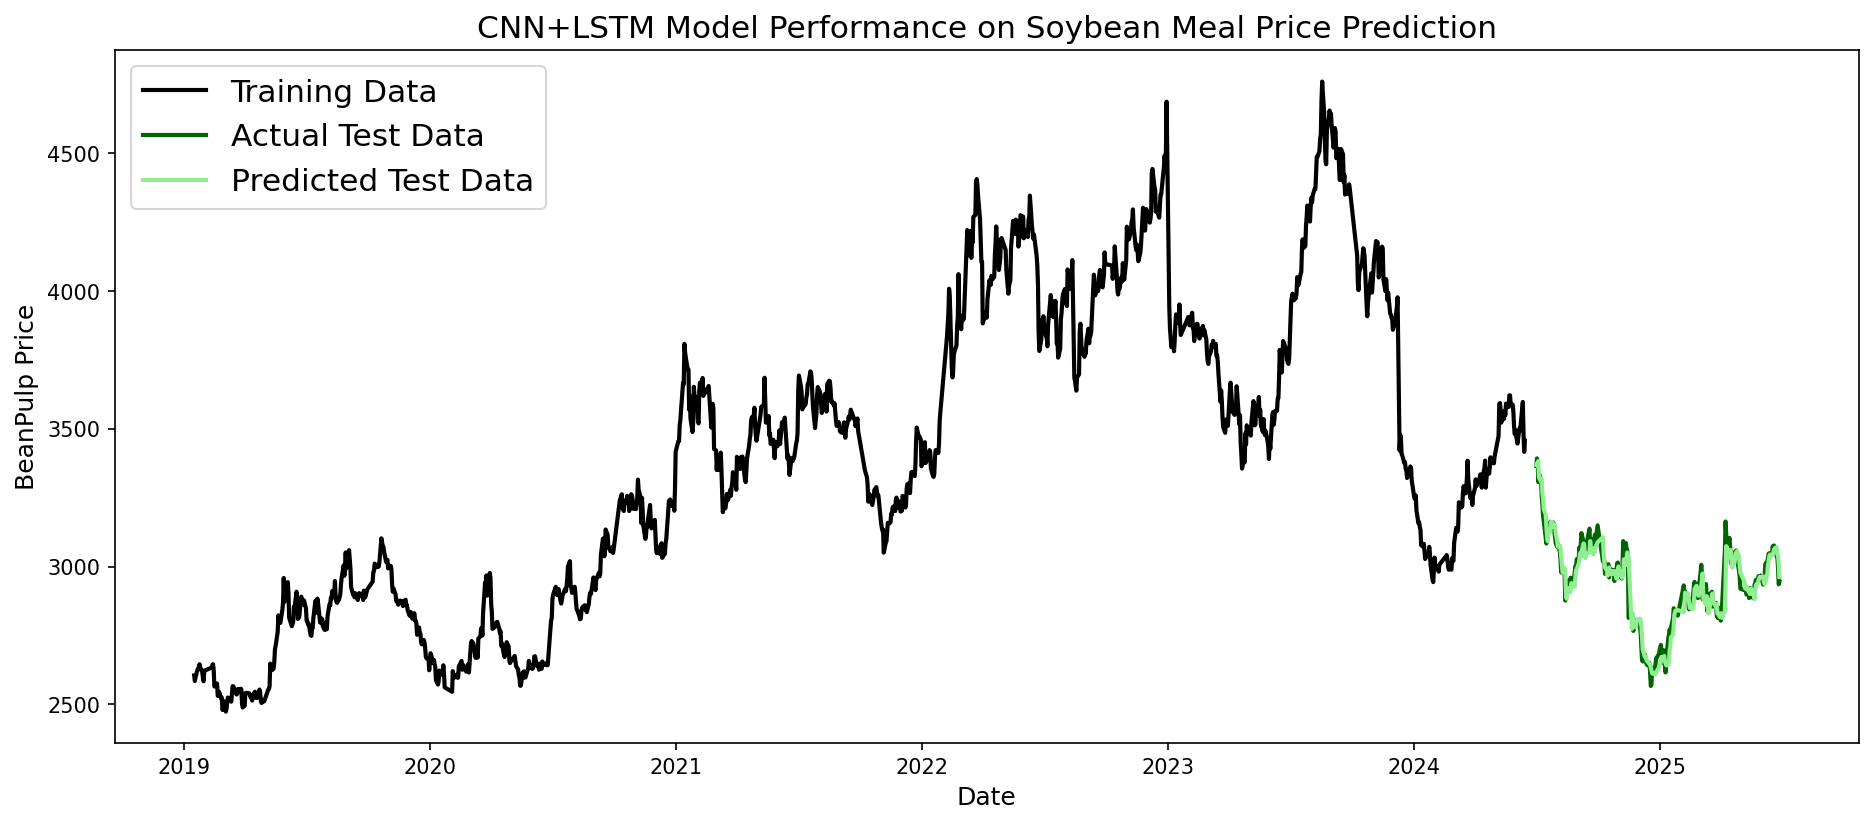

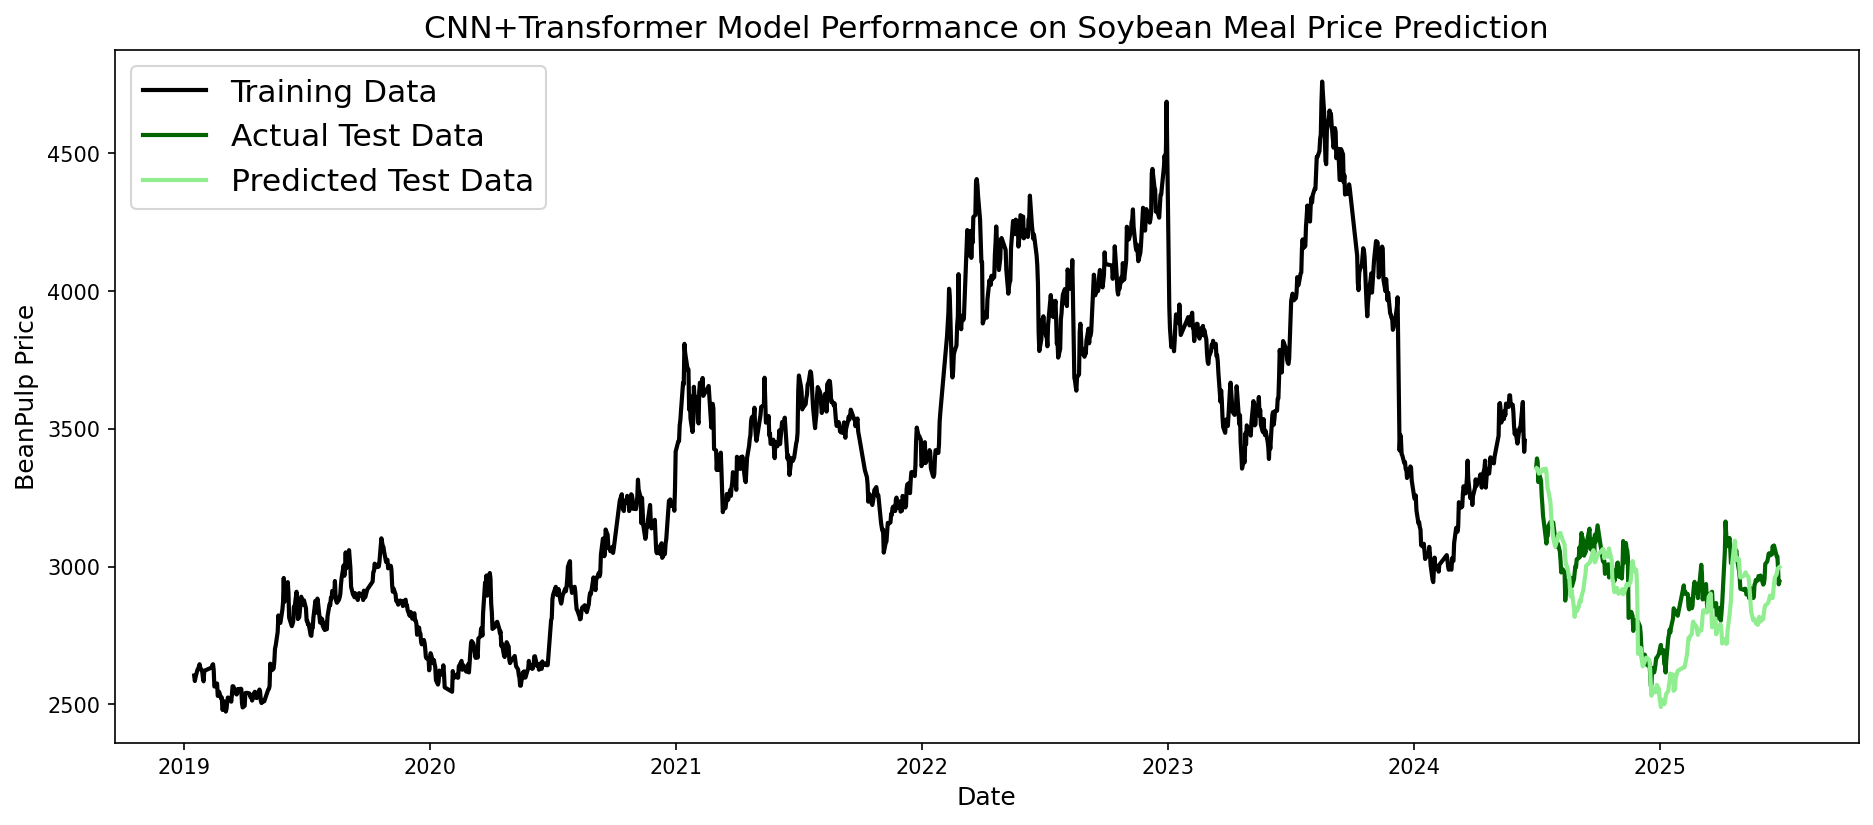

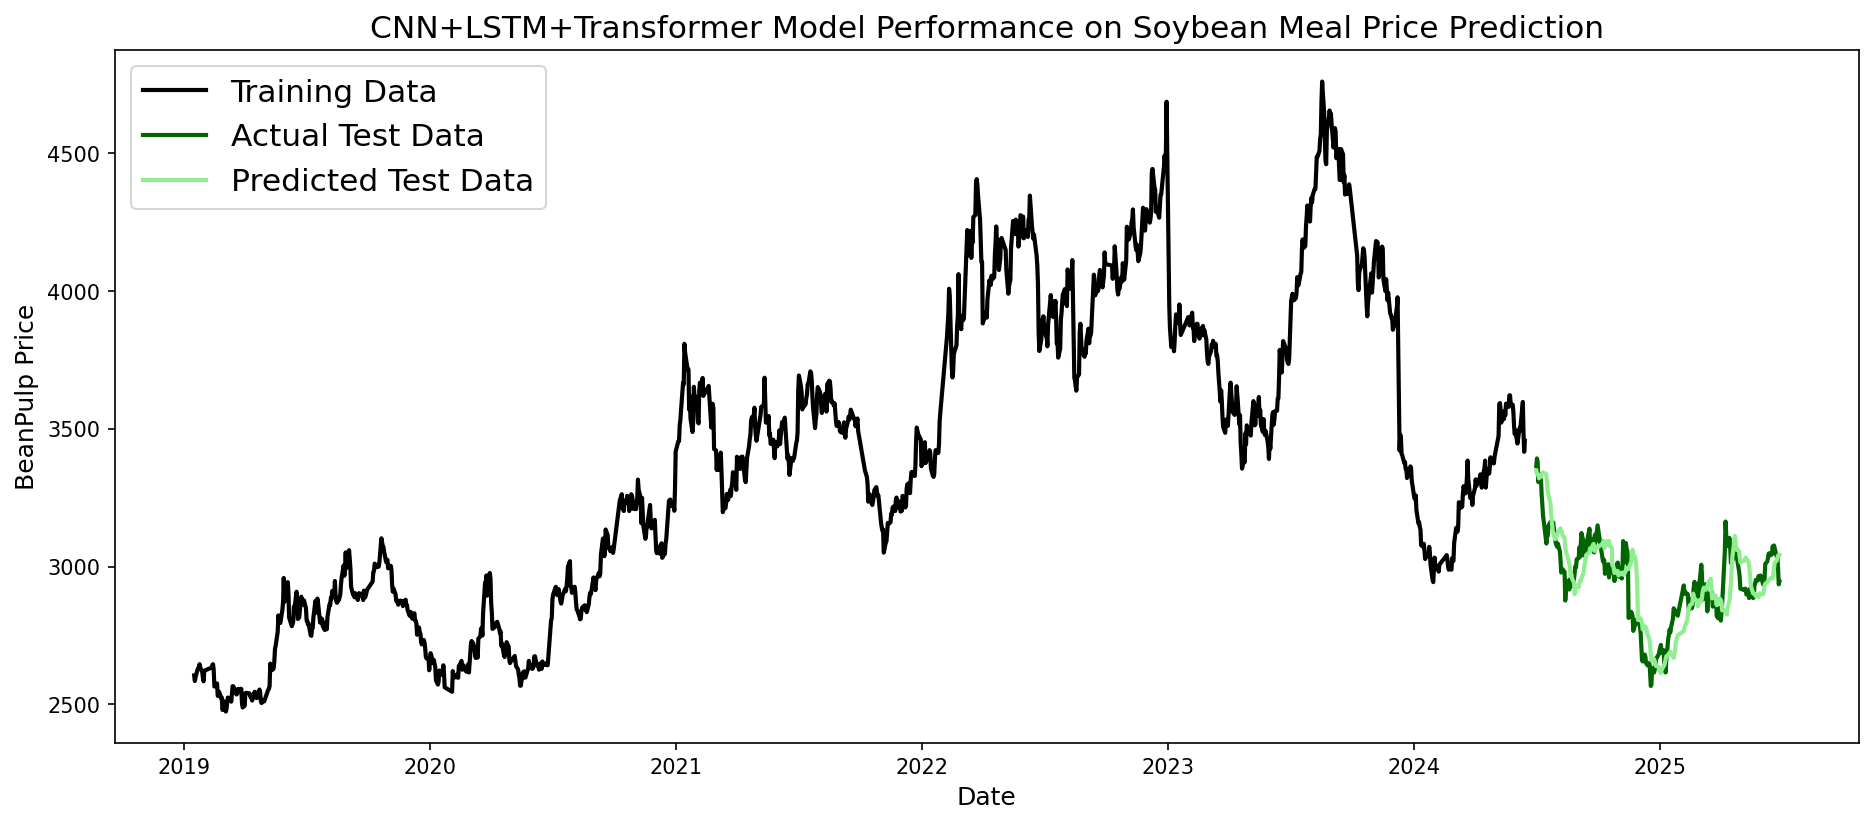

In [21]:
#Visualize the results of the LSTM model
y_test_true = scaler.inverse_transform(y_test_2d).flatten()
y_test_pred_lstm = scaler.inverse_transform(y_pred_lstm_2d).flatten()

plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes', edgecolor='black')
plt.plot(df_meal['Date'].iloc[:-test_size], scaler.inverse_transform(train_data_scaled), color='black', lw=2)
plt.plot(df_meal['Date'].iloc[-len(y_test_true):], y_test_true, color='darkgreen', lw=2)
plt.plot(df_meal['Date'].iloc[-len(y_test_pred_lstm):], y_test_pred_lstm, color='lightgreen', lw=2)
plt.title('LSTM Model Performance on Soybean Meal Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('BeanPulp Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

# Visualize the results of CNN+LSTM models
y_test_pred_cnn_lstm = scaler.inverse_transform(y_pred_cnn_lstm_2d).flatten()

plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes', edgecolor='black')
plt.plot(df_meal['Date'].iloc[:-test_size], scaler.inverse_transform(train_data_scaled), color='black', lw=2)
plt.plot(df_meal['Date'].iloc[-len(y_test_true):], y_test_true, color='darkgreen', lw=2)
plt.plot(df_meal['Date'].iloc[-len(y_test_pred_cnn_lstm):], y_test_pred_cnn_lstm, color='lightgreen', lw=2)
plt.title('CNN+LSTM Model Performance on Soybean Meal Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('BeanPulp Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

# Visualize the results of the CNN+Transformer model
y_test_pred_cnn_transformer = scaler.inverse_transform(y_pred_cnn_transformer_2d).flatten()

plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes', edgecolor='black')
plt.plot(df_meal['Date'].iloc[:-test_size], scaler.inverse_transform(train_data_scaled), color='black', lw=2)
plt.plot(df_meal['Date'].iloc[-len(y_test_true):], y_test_true, color='darkgreen', lw=2)
plt.plot(df_meal['Date'].iloc[-len(y_test_pred_cnn_transformer):], y_test_pred_cnn_transformer, color='lightgreen', lw=2)
plt.title('CNN+Transformer Model Performance on Soybean Meal Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('BeanPulp Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

# Visualize the results of CNN+LSTM+Transformer models
y_test_pred_cnn_lstm_transformer = scaler.inverse_transform(y_pred_cnn_lstm_transformer_2d).flatten()

plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes', edgecolor='black')
plt.plot(df_meal['Date'].iloc[:-test_size], scaler.inverse_transform(train_data_scaled), color='black', lw=2)
plt.plot(df_meal['Date'].iloc[-len(y_test_true):], y_test_true, color='darkgreen', lw=2)
plt.plot(df_meal['Date'].iloc[-len(y_test_pred_cnn_lstm_transformer):], y_test_pred_cnn_lstm_transformer, color='lightgreen', lw=2)
plt.title('CNN+LSTM+Transformer Model Performance on Soybean Meal Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('BeanPulp Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

## Future Price Prediction (Hybrid Models)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
The predicted price of the LSTM model for the next X trading days: [2936 2931 2927 2924 2920 2916 2912 2907 2903 2899]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
The predicted price of the CNN+LSTM model for the next X trading days: [2935 2941 2936 2945 2944 2952 2954 2959 2961 2965

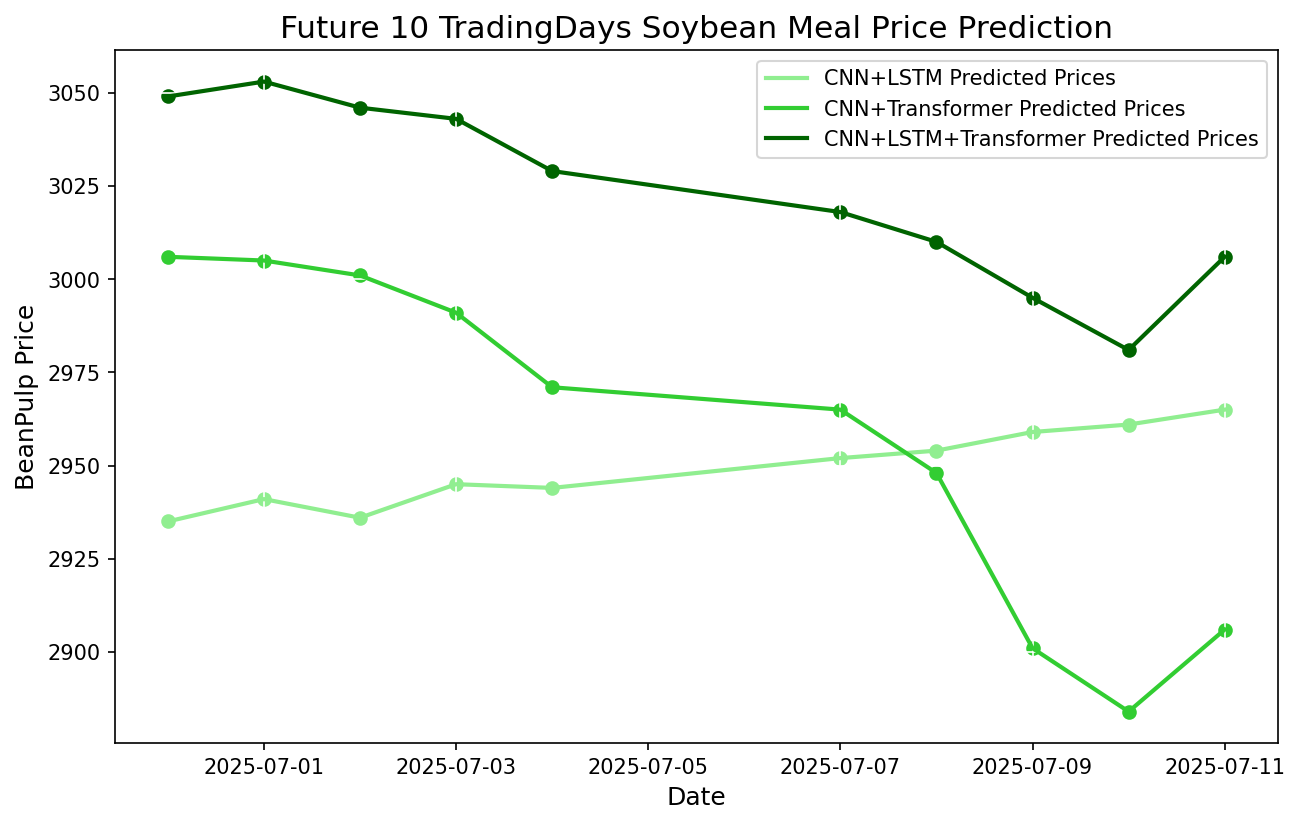

In [23]:
# Predict the price for the next X days
def predict_future_prices(model, last_window, num_days, scaler):
    future_predictions = []
    current_window = last_window

    for _ in range(num_days):
        prediction = model.predict(current_window[np.newaxis, :, :])
        future_predictions.append(prediction[0, 0])
        # Update sliding window
        current_window = np.append(current_window[1:], prediction[0, 0]).reshape(-1, 1)

    # Inverse scaling
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()
    # Convert to integers (rounded)
    future_predictions = np.round(future_predictions).astype(int)
    return future_predictions

# Get the data of the last window
last_window = test_data_scaled[-window_size:]

# Predict the price for the next X days
future_days = 10

# Prediction Using the LSTM model
future_prices_lstm = predict_future_prices(lstm_model, last_window, future_days, scaler)
print("The predicted price of the LSTM model for the next X trading days:", future_prices_lstm)

# Prediction using CNN+LSTM models
future_prices_cnn_lstm = predict_future_prices(cnn_lstm_model, last_window, future_days, scaler)
print("The predicted price of the CNN+LSTM model for the next X trading days:", future_prices_cnn_lstm)

# Prediction using CNN+Transformer models
future_prices_cnn_transformer = predict_future_prices(cnn_transformer_model, last_window, future_days, scaler)
print("The predicted price of the CNN+Transformer model for the next X trading days:", future_prices_cnn_transformer)

# Use CNN+LSTM+Transformer models for prediction
future_prices_cnn_lstm_transformer = predict_future_prices(cnn_lstm_transformer_model, last_window, future_days, scaler)
print("The predicted price of the CNN+LSTM+Transformer model for the next X trading days:", future_prices_cnn_lstm_transformer)

# Visualize the predicted price for the next X days
future_dates = pd.bdate_range(start=df_meal['Date'].iloc[-1] + pd.Timedelta(days=1), periods=future_days)

plt.figure(figsize=(10, 6), dpi=150)
plt.plot(future_dates, future_prices_cnn_lstm, color='lightgreen', lw=2, label='CNN+LSTM Predicted Prices')
plt.scatter(future_dates, future_prices_cnn_lstm, color='lightgreen')
plt.plot(future_dates, future_prices_cnn_transformer, color='limegreen', lw=2, label='CNN+Transformer Predicted Prices')
plt.scatter(future_dates, future_prices_cnn_transformer, color='limegreen')
plt.plot(future_dates, future_prices_cnn_lstm_transformer, color='darkgreen', lw=2, label='CNN+LSTM+Transformer Predicted Prices')
plt.scatter(future_dates, future_prices_cnn_lstm_transformer, color='darkgreen')
plt.title('Future 10 TradingDays Soybean Meal Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('BeanPulp Price', fontsize=12)
plt.legend()
plt.grid(color='white')
plt.show()


# Trading Strategy Implementation
## 1. Position Sizing
- **Trading Execution**
  - Initial Setup
  - Separate 50,000 accounts for soybean meal and oil
  - Tracks positions, prices, profits, and consumption
  - Calculates ATR for both commodities

- **Trading Logic**
  - Entry: MACD histogram troughs + trend confirmation + breakout

- **Exit Conditions**
  - Contract rollover
  - ATR-based trailing stops
  - MACD histogram peaks

## 2. Risk Management
- Position sizing based on account equity
- Commission costs (1.5 per lot)
- Rest period avoidance
- Regular profit withdrawals (every 14+ days)

## 3. Strategy Characteristics
- Trend-following with MACD indicators
- Breakout entry system
- Volatility-based risk management (ATR stops)
- Systematic profit-taking
- Contract-aware trading
- Rest-period avoidance

## Opening a position, trading logic; Take-profit and stop-loss Initial capital establishment and consumption withdrawal

In [19]:
def calculate_lots(capital, price, max_lots=200):
    """
    Calculate the number of open positions, which should not exceed 200
    When the funds exceed 500,000, use a 50% position; otherwise, use a 70% position
    """
    # Determine the position ratio based on the amount of funds
    position_ratio = 0.5 if capital > 500000 else 0.7
    
    lots = int((capital * position_ratio) // (price + 1000))
    return min(lots, max_lots)

def calculate_atr(data, period=14):
    """Calculate the ATR index"""
    high = data['High']
    low = data['Low']
    close = data['Close'].shift(1)
    
    tr1 = high - low
    tr2 = abs(high - close)
    tr3 = abs(low - close)
    
    tr = pd.DataFrame({'TR1': tr1, 'TR2': tr2, 'TR3': tr3}).max(axis=1)
    atr = tr.rolling(window=period).mean()
    return atr

def calculate_consumption(start_capital, current_capital):
    """
    Calculate the amount of consumption that can be withdrawn in two cycles
    start_capital: Initial capital
    current_capital: Current funds
    Return: Extractable consumption amount
    """
    profit = current_capital - start_capital
    if profit <= 0:  # No withdrawal will be made if there is a loss
        return 0
        
    consumption = profit * 0.3  # Take out 30% of the profit
    
    # Limit the withdrawal amount to between 5,000 and 10,000
    if consumption < 5000:
        return 0  # If the amount is less than 5,000, no withdrawal will be made
    elif consumption > 10000:
        return 10000
    else:
        return consumption

# Add ATR calculation
last_year_meal['ATR'] = calculate_atr(last_year_meal)
last_year_oil['ATR'] = calculate_atr(last_year_oil)

# Initialize Variables
initial_capital = 50000  # Initial Capital
capital_meal = initial_capital  # Soybean Meal account
capital_oil = initial_capital   # Soybean Oil Account
position_meal = 0  # Soybean meal position
position_oil = 0   # Soybean oil holdings
last_trade_price_meal = 0
last_trade_price_oil = 0
total_profit_meal = 0
total_profit_oil = 0
lots_meal = 0
lots_oil = 0
entry_date_meal = None
entry_date_oil = None
entry_price_meal = 0  # Soybean meal opening price
entry_price_oil = 0   # Opening price of soybean oil

# Opening price of soybean oil
capital_history_meal = []
capital_history_oil = []
dates_history_meal = []
dates_history_oil = []

# Used to track the initial capital and time for two cycles
last_consumption_date_meal = None
last_consumption_date_oil = None
period_start_capital_meal = capital_meal
period_start_capital_oil = capital_oil
total_consumption_meal = 0
total_consumption_oil = 0

# Used to record the history of consumption withdrawals
consumption_history_meal = []
consumption_dates_meal = []
consumption_history_oil = []
consumption_dates_oil = []

## Trade soybean meal, trade soybean oil

In [20]:
# Trade soybean meal
print("\n=== Soybean meal trading ===")
for i in range(2, len(last_year_meal) - 2):
    current_date = last_year_meal['Date'].iloc[i]
    
    # Check if it is during the break
    if is_rest_period(current_date):
        continue
        
    current_price = last_year_meal['Close'].iloc[i]
    next_day_open = last_year_meal['Open'].iloc[i + 1]  # Get the opening price of the next day
    next_day_high = last_year_meal['High'].iloc[i + 1]  # Get the highest price of the next day
    next_day_low = last_year_meal['Low'].iloc[i + 1]    # Get the lowest price for the next day
    next_day_close = last_year_meal['Close'].iloc[i + 1]  # Get the closing price of the next day
    current_atr = last_year_meal['ATR'].iloc[i]
    
    # Judging Trends
    trend = determine_trend(last_year_meal, i)
    
    # Check if it is necessary to close positions due to contract switching
    if position_meal != 0:
        if should_close_meal_position(current_date, entry_date_meal):
            if position_meal == 1:  # Close long positions
                profit = (current_price - entry_price_meal) * lots_meal * 10
                commission = lots_meal * 1.5
                total_profit_meal += profit - commission
                capital_meal += profit - commission
                print(f"[ Soybean Meal Flat Long ] Contract Switch and Close Position - Date: {current_date}, "
                      f" Price: {current_price:.2f}, earnings: {profit:.2f}, "
                      f" commission: {commission:.2f}, net income: {profit-commission:.2f}")
            else:  # Close out the position
                profit = (entry_price_meal - current_price) * lots_meal * 10
                commission = lots_meal * 1.5
                total_profit_meal += profit - commission
                capital_meal += profit - commission
                print(f"[ Soybean Meal Short Position ] Contract Switch and Close - Date: {current_date}, "
                      f" Price: {current_price:.2f}, earnings: {profit:.2f}, "
                      f" commission: {commission:.2f}, net income: {profit-commission:.2f}")
            
            position_meal = 0
            capital_history_meal.append(capital_meal)
            dates_history_meal.append(current_date)
            entry_date_meal = None
            
            # Check if the consumption can be withdrawn
            if last_consumption_date_meal is None or (current_date - last_consumption_date_meal).days >= 14:
                consumption = calculate_consumption(period_start_capital_meal, capital_meal)
                if consumption > 0:
                    capital_meal -= consumption
                    total_consumption_meal += consumption
                    consumption_history_meal.append(consumption)
                    consumption_dates_meal.append(current_date)
                    last_consumption_date_meal = current_date
                    period_start_capital_meal = capital_meal
                    print(f"[ Soybean Meal Consumption ] Withdrawal consumption - date: {current_date}, amount: {consumption:.2f}")
            continue

    # Check whether it is within the contract trading period before opening a position
    current_contract, contract_end_date = get_meal_contract_info(current_date)
    if current_contract is None:  # Skip if there is no suitable contract
        continue
        
    if position_meal == 0:
        # Check if troughs have formed
        if is_histogram_trough(last_year_meal, i):
            trough_day_high = last_year_meal['High'].iloc[i]
            trough_day_low = last_year_meal['Low'].iloc[i]
            
            if trend == 1:  # In an uptrend, at the trough, only go long
                if next_day_high >= trough_day_high:
                    position_meal = 1
                    entry_price_meal = trough_day_high  # Record the opening position price
                    last_trade_price_meal = entry_price_meal
                    lots_meal = calculate_lots(capital_meal, entry_price_meal)
                    entry_date_meal = last_year_meal['Date'].iloc[i + 1]
                    commission = lots_meal * 1.5
                    capital_meal -= commission
                    print(f"[ Soybean Meal Opens Long ]{current_contract} Contract Uptrend trough Breaks through - Date: {entry_date_meal}, "
                          f" Price: {entry_price_meal:.2f}, lot: {lots_meal}, commission: {commission:.2f}")
                
            elif trend == -1:  # In a downtrend, only short the troughs
                if next_day_low <= trough_day_low:
                    position_meal = -1
                    entry_price_meal = trough_day_low  # Record the opening position price
                    last_trade_price_meal = entry_price_meal
                    lots_meal = calculate_lots(capital_meal, entry_price_meal)
                    entry_date_meal = last_year_meal['Date'].iloc[i + 1]
                    commission = lots_meal * 1.5
                    capital_meal -= commission
                    print(f"[ Soybean Meal Open ]{current_contract} Contract Downtrend trough Breakthrough - Date: {entry_date_meal}, "
                          f" Price: {entry_price_meal:.2f}, lot: {lots_meal}, commission: {commission:.2f}")

    # Check the stop-loss and liquidation conditions
    if position_meal != 0:
        current_atr = last_year_meal['ATR'].iloc[i]
        current_close = last_year_meal['Close'].iloc[i]
        
        if position_meal == 1:  # Long position
            # Calculate the moving stop-loss price
            stop_loss_price = max(last_trade_price_meal - current_atr,  # Initial stop-loss price
                                current_close - current_atr)  # Moving stop-loss price
            
            # Update the highest trading price as the benchmark for moving stop-loss
            if current_close > last_trade_price_meal:
                last_trade_price_meal = current_close
            
            # Check if the stop-loss has been triggered
            if next_day_close <= stop_loss_price:  # Check the stop-loss using the closing price of the next day
                profit = (next_day_close - entry_price_meal) * lots_meal * 10
                commission = lots_meal * 1.5
                total_profit_meal += profit - commission
                capital_meal += profit - commission
                print(f"[ Soybean Meal Flat ] Moving Stop-loss - Date: {last_year_meal['Date'].iloc[i + 1]}, "
                      f" Price: {next_day_close:.2f}, stop-loss price: {stop_loss_price:.2f}, "
                      f" Income: {profit:.2f}, commission: {commission :.2f}, net income: {profit-commission:.2f}")
                position_meal = 0
                capital_history_meal.append(capital_meal)
                dates_history_meal.append(last_year_meal['Date'].iloc[i + 1])
                entry_date_meal = None
                
                # Check if the consumption can be withdrawn
                if last_consumption_date_meal is None or (current_date - last_consumption_date_meal).days >= 14:
                    consumption = calculate_consumption(period_start_capital_meal, capital_meal)
                    if consumption > 0:
                        capital_meal -= consumption
                        total_consumption_meal += consumption
                        consumption_history_meal.append(consumption)
                        consumption_dates_meal.append(current_date)
                        last_consumption_date_meal = current_date
                        period_start_capital_meal = capital_meal
                        print(f"[ Soybean Meal Consumption ] Withdrawal consumption - date: {current_date}, amount: {consumption:.2f}")
                continue
                
        else:  # Short position
            # Calculate the moving stop-loss price
            stop_loss_price = min(last_trade_price_meal + current_atr,  # Initial stop-loss price
                                current_close + current_atr)  # Moving stop-loss price
            
            # Update the minimum trading price as the benchmark for moving stop-loss
            if current_close < last_trade_price_meal:
                last_trade_price_meal = current_close
            
            # Check if the stop-loss has been triggered
            if next_day_close >= stop_loss_price:  # Check the stop-loss using the closing price of the next day
                profit = (entry_price_meal - next_day_close) * lots_meal * 10
                commission = lots_meal * 1.5
                total_profit_meal += profit - commission
                capital_meal += profit - commission
                print(f"[ Soybean Meal Flat ] Moving Stop-loss - Date: {last_year_meal['Date'].iloc[i + 1]}, "
                      f" Price: {next_day_close:.2f}, stop-loss price: {stop_loss_price:.2f}, "
                      f" Income: {profit:.2f}, commission: {commission :.2f}, net income: {profit-commission:.2f}")
                position_meal = 0
                capital_history_meal.append(capital_meal)
                dates_history_meal.append(last_year_meal['Date'].iloc[i + 1])
                entry_date_meal = None
                
                # Check if the consumption can be withdrawn
                if last_consumption_date_meal is None or (current_date - last_consumption_date_meal).days >= 14:
                    consumption = calculate_consumption(period_start_capital_meal, capital_meal)
                    if consumption > 0:
                        capital_meal -= consumption
                        total_consumption_meal += consumption
                        consumption_history_meal.append(consumption)
                        consumption_dates_meal.append(current_date)
                        last_consumption_date_meal = current_date
                        period_start_capital_meal = capital_meal
                        print(f"[ Soybean Meal Consumption ] Withdrawal consumption - date: {current_date}, amount: {consumption:.2f}")
                continue
        
        # Check if you have reached the peak
        if is_histogram_peak(last_year_meal, i):
            if position_meal == 1:  # Close long positions
                profit = (next_day_close - entry_price_meal) * lots_meal * 10
                commission = lots_meal * 1.5
                total_profit_meal += profit - commission
                capital_meal += profit - commission
                print(f"[ Soybean Meal Flat Long ]MACD Peak Closing Position - Date: {last_year_meal['Date'].iloc[i + 1]}, "
                      f"price: {next_day_close: .2f}, earnings: {profit: .2f}, commission: {commission:.2f}, " 
                      f" Net income: {profit-commission:.2f}")
            else:  # Close out the position
                profit = (entry_price_meal - next_day_close) * lots_meal * 10
                commission = lots_meal * 1.5
                total_profit_meal += profit - commission
                capital_meal += profit - commission
                print(f"[ Soybean Meal Short ]MACD Peak Closing Position - Date: {last_year_meal['Date'].iloc[i + 1]}, "
                      f"price: {next_day_close: .2f}, earnings: {profit: .2f}, commission: {commission:.2f}, " 
                      f" Net income: {profit-commission:.2f}")
            
            position_meal = 0
            capital_history_meal.append(capital_meal)
            dates_history_meal.append(last_year_meal['Date'].iloc[i + 1])
            entry_date_meal = None
            
            # Check if the consumption can be withdrawn
            if last_consumption_date_meal is None or (current_date - last_consumption_date_meal).days >= 14:
                consumption = calculate_consumption(period_start_capital_meal, capital_meal)
                if consumption > 0:
                    capital_meal -= consumption
                    total_consumption_meal += consumption
                    consumption_history_meal.append(consumption)
                    consumption_dates_meal.append(current_date)
                    last_consumption_date_meal = current_date
                    period_start_capital_meal = capital_meal
                    print(f"[ Soybean Meal Consumption ] Withdrawal consumption - date: {current_date}, amount: {consumption:.2f}")

# Trade Soybean Oil
print("\n=== Soybean oil trading ===")
for i in range(2, len(last_year_oil) - 2):
    current_date = last_year_oil['Date'].iloc[i]
    
    # Check if it is during the break
    if is_rest_period(current_date):
        continue
        
    current_price = last_year_oil['Close'].iloc[i]
    next_day_open = last_year_oil['Open'].iloc[i + 1]  # Get the opening price of the next day
    next_day_high = last_year_oil['High'].iloc[i + 1]  # Get the highest price of the next day
    next_day_low = last_year_oil['Low'].iloc[i + 1]    # Get the lowest price for the next day
    next_day_close = last_year_oil['Close'].iloc[i + 1]  # Get the closing price of the next day
    current_atr = last_year_oil['ATR'].iloc[i]
    
    # Judging Trends
    trend = determine_trend(last_year_oil, i)
    
    # Check if it is necessary to close positions due to contract switching
    if position_oil != 0:
        if should_close_oil_position(current_date, entry_date_oil):
            if position_oil == 1:  # Close long positions
                profit = (current_price - entry_price_oil) * lots_oil * 10
                commission = lots_oil * 1.5
                total_profit_oil += profit - commission
                capital_oil += profit - commission
                print(f"[ Soybean Oil Close Long ] Contract Switch Close - Date: {current_date}, "
                      f"price: {current_price:.2f}, earnings: {profit:.2f}, "
                      f"commission {commission:.2f}, Net income: {profit-commission:.2f}")
            else:  # Close out the position
                profit = (entry_price_oil - current_price) * lots_oil * 10
                commission = lots_oil * 1.5
                total_profit_oil += profit - commission
                capital_oil += profit - commission
                print(f"[ Soybean Oil Short Position ] Contract Switch and Close - Date: {current_date}, "
                      f"price: {current_price:.2f}, earnings: {profit:.2f}, "
                      f"commission: {commission:.2f}, Net income: {profit-commission:.2f}")
            
            position_oil = 0
            capital_history_oil.append(capital_oil)
            dates_history_oil.append(current_date)
            entry_date_oil = None
            
            # Check if the consumption can be withdrawn
            if last_consumption_date_oil is None or (current_date - last_consumption_date_oil).days >= 14:
                consumption = calculate_consumption(period_start_capital_oil, capital_oil)
                if consumption > 0:
                    capital_oil -= consumption
                    total_consumption_oil += consumption
                    consumption_history_oil.append(consumption)
                    consumption_dates_oil.append(current_date)
                    last_consumption_date_oil = current_date
                    period_start_capital_oil = capital_oil
                    print(f"[ Soybean Oil Consumption ] Withdrawal consumption - Date: {current_date}, amount: {consumption:.2f}")
            continue

    # Check whether it is within the contract trading period before opening a position
    current_contract, contract_end_date = get_oil_contract_info(current_date)
    if current_contract is None:  # Skip if there is no suitable contract
        continue
        
    if position_oil == 0:
        # Check if troughs have formed
        if is_histogram_trough(last_year_oil, i):
            trough_day_high = last_year_oil['High'].iloc[i]
            trough_day_low = last_year_oil['Low'].iloc[i]
            
            if trend == 1:  # In an uptrend, at the trough, only go long
                if next_day_high >= trough_day_high:
                    position_oil = 1
                    entry_price_oil = trough_day_high  # Record the opening position price
                    last_trade_price_oil = entry_price_oil
                    lots_oil = calculate_lots(capital_oil, entry_price_oil)
                    entry_date_oil = last_year_oil['Date'].iloc[i + 1]
                    commission = lots_oil * 1.5
                    capital_oil -= commission
                    print(f"[ Soybean Oil Open Long ]{current_contract} Contract Uptrend trough Breakthrough - Date: {entry_date_oil}, "
                          f"price: {entry_price_oil:.2f}, lots: {lots_oil}, commission: {commission:.2f}")
                
            elif trend == -1:  # In a downtrend, only short the troughs
                if next_day_low <= trough_day_low:
                    position_oil = -1
                    entry_price_oil = trough_day_low  # Record the opening position price
                    last_trade_price_oil = entry_price_oil
                    lots_oil = calculate_lots(capital_oil, entry_price_oil)
                    entry_date_oil = last_year_oil['Date'].iloc[i + 1]
                    commission = lots_oil * 1.5
                    capital_oil -= commission
                    print(f"[ Soybean Oil Open ]{current_contract} Contract Downtrend trough Broken - Date: {entry_date_oil}, "
                          f"price: {entry_price_oil:.2f}, lots: {lots_oil}, commission: {commission:.2f}")

    # Check the stop-loss and liquidation conditions
    if position_oil != 0:
        current_atr = last_year_oil['ATR'].iloc[i]
        current_close = last_year_oil['Close'].iloc[i]
        
        if position_oil == 1:  # Long position
            # Calculate the moving stop-loss price
            stop_loss_price = max(last_trade_price_oil - current_atr,  # Initial stop-loss price
                                current_close - current_atr)  # Moving stop-loss price
            
            # Update the highest trading price as the benchmark for moving stop-loss
            if current_close > last_trade_price_oil:
                last_trade_price_oil = current_close
            
            # Check if the stop-loss has been triggered
            if next_day_close <= stop_loss_price:  # Check the stop-loss using the closing price of the next day
                profit = (next_day_close - entry_price_oil) * lots_oil * 10
                commission = lots_oil * 1.5
                total_profit_oil += profit - commission
                capital_oil += profit - commission
                print(f"[ Soybean Oil Flat ] Moving Stop-loss - Date: {last_year_oil['Date'].iloc[i + 1]}, "
                      f"price: {next_day_close:.2f}, Stop-loss price: {stop_loss_price:.2f}, "
                      f"earnings: {profit:.2f}, commission: {commission:.2f}, Net income: {profit-commission:.2f}")
                position_oil = 0
                capital_history_oil.append(capital_oil)
                dates_history_oil.append(last_year_oil['Date'].iloc[i + 1])
                entry_date_oil = None
                
                # Check if the consumption can be withdrawn
                if last_consumption_date_oil is None or (current_date - last_consumption_date_oil).days >= 14:
                    consumption = calculate_consumption(period_start_capital_oil, capital_oil)
                    if consumption > 0:
                        capital_oil -= consumption
                        total_consumption_oil += consumption
                        consumption_history_oil.append(consumption)
                        consumption_dates_oil.append(current_date)
                        last_consumption_date_oil = current_date
                        period_start_capital_oil = capital_oil
                        print(f"[ Soybean Oil Consumption ] Withdrawal consumption - Date: {current_date}, amount: {consumption:.2f}")
                continue
                
        else:  # Short position
            # Calculate the moving stop-loss price
            stop_loss_price = min(last_trade_price_oil + current_atr,  # Initial stop-loss price
                                current_close + current_atr)  # Moving stop-loss price
            
            # Update the minimum trading price as the benchmark for moving stop-loss
            if current_close < last_trade_price_oil:
                last_trade_price_oil = current_close
            
            # Check if the stop-loss has been triggered
            if next_day_close >= stop_loss_price:  # Check the stop-loss using the closing price of the next day
                profit = (entry_price_oil - next_day_close) * lots_oil * 10
                commission = lots_oil * 1.5
                total_profit_oil += profit - commission
                capital_oil += profit - commission
                print(f"[ Soybean Oil Flat ] Moving Stop-loss - Date: {last_year_oil['Date'].iloc[i + 1]}, "
                      f"price: {next_day_close:.2f}, Stop-loss price: {stop_loss_price:.2f}, "
                      f"earnings: {profit:.2f}, commission: {commission:.2f}, Net income: {profit-commission:.2f}")
                position_oil = 0
                capital_history_oil.append(capital_oil)
                dates_history_oil.append(last_year_oil['Date'].iloc[i + 1])
                entry_date_oil = None
                
                # Check if the consumption can be withdrawn
                if last_consumption_date_oil is None or (current_date - last_consumption_date_oil).days >= 14:
                    consumption = calculate_consumption(period_start_capital_oil, capital_oil)
                    if consumption > 0:
                        capital_oil -= consumption
                        total_consumption_oil += consumption
                        consumption_history_oil.append(consumption)
                        consumption_dates_oil.append(current_date)
                        last_consumption_date_oil = current_date
                        period_start_capital_oil = capital_oil
                        print(f"[ Soybean Oil Consumption ] Withdrawal consumption - Date: {current_date}, amount: {consumption:.2f}")
                continue
        
        # Check if you have reached the peak
        if is_histogram_peak(last_year_oil, i):
            if position_oil == 1:  # Close long positions
                profit = (next_day_close - entry_price_oil) * lots_oil * 10
                commission = lots_oil * 1.5
                total_profit_oil += profit - commission
                capital_oil += profit - commission
                print(f"[ Soybean Oil Flat Long ]MACD Peak Closing Position - Date: {last_year_oil['Date'].iloc[i + 1]}, "
                      f"price: {next_day_close:.2f}, earnings: {profit:.2f}, commission: {commission:.2f}, "
                      f"Net income: {profit-commission:.2f}")
            else:  # Close out the position
                profit = (entry_price_oil - next_day_close) * lots_oil * 10
                commission = lots_oil * 1.5
                total_profit_oil += profit - commission
                capital_oil += profit - commission
                print(f"[ Soybean Oil Liquidation ]MACD Peak Liquidation - Date: {last_year_oil['Date'].iloc[i + 1]}, "
                      f"price: {next_day_close:.2f}, earnings: {profit:.2f}, commission: {commission:.2f}, "
                      f"Net income: {profit-commission:.2f}")
            
            position_oil = 0
            capital_history_oil.append(capital_oil)
            dates_history_oil.append(last_year_oil['Date'].iloc[i + 1])
            entry_date_oil = None
            
            # Check if the consumption can be withdrawn
            if last_consumption_date_oil is None or (current_date - last_consumption_date_oil).days >= 14:
                consumption = calculate_consumption(period_start_capital_oil, capital_oil)
                if consumption > 0:
                    capital_oil -= consumption
                    total_consumption_oil += consumption
                    consumption_history_oil.append(consumption)
                    consumption_dates_oil.append(current_date)
                    last_consumption_date_oil = current_date
                    period_start_capital_oil = capital_oil
                    print(f"[ Soybean Oil Consumption ] Withdrawal consumption - Date: {current_date}, amount: {consumption:.2f}")



=== Soybean meal trading ===
[ Soybean Meal Open ]2401 Contract Downtrend trough Breakthrough - Date: 2023-10-09 00:00:00,  Price: 4350.00, lot: 6, commission: 9.00
[ Soybean Meal Short ]MACD Peak Closing Position - Date: 2023-10-12 00:00:00, price:  4066.00, earnings:  17040.00, commission: 9.00,  Net income: 17031.00
[ Soybean Meal Consumption ] Withdrawal consumption - date: 2023-10-11 00:00:00, amount: 5106.60
[ Soybean Meal Open ]2401 Contract Downtrend trough Breakthrough - Date: 2023-10-23 00:00:00,  Price: 4118.00, lot: 8, commission: 12.00
[ Soybean Meal Short ]MACD Peak Closing Position - Date: 2023-10-25 00:00:00, price:  3957.00, earnings:  12880.00, commission: 12.00,  Net income: 12868.00
[ Soybean Meal Open ]2401 Contract Downtrend trough Breakthrough - Date: 2023-10-31 00:00:00,  Price: 4005.00, lot: 10, commission: 15.00
[ Soybean Meal Flat ] Moving Stop-loss - Date: 2023-11-03 00:00:00,  Price: 4110.00, stop-loss price: 4074.71,  Income: -10500.00, commission: 15.00,

## Output and capital curve


=== Statistics on soybean meal strategies ===
Initial capital: 50000.00
Final funds: 170599.40
Total revenue: 185139.50
Total consumption withdrawal: 63449.60
Annualized rate of return: 84.72%

=== Statistics on soybean oil strategies ===
Initial capital: 50000.00
Final funds: 88110.00
Total revenue: 54925.00
Total consumption withdrawal: 16680.00
Annualized rate of return: 32.75%


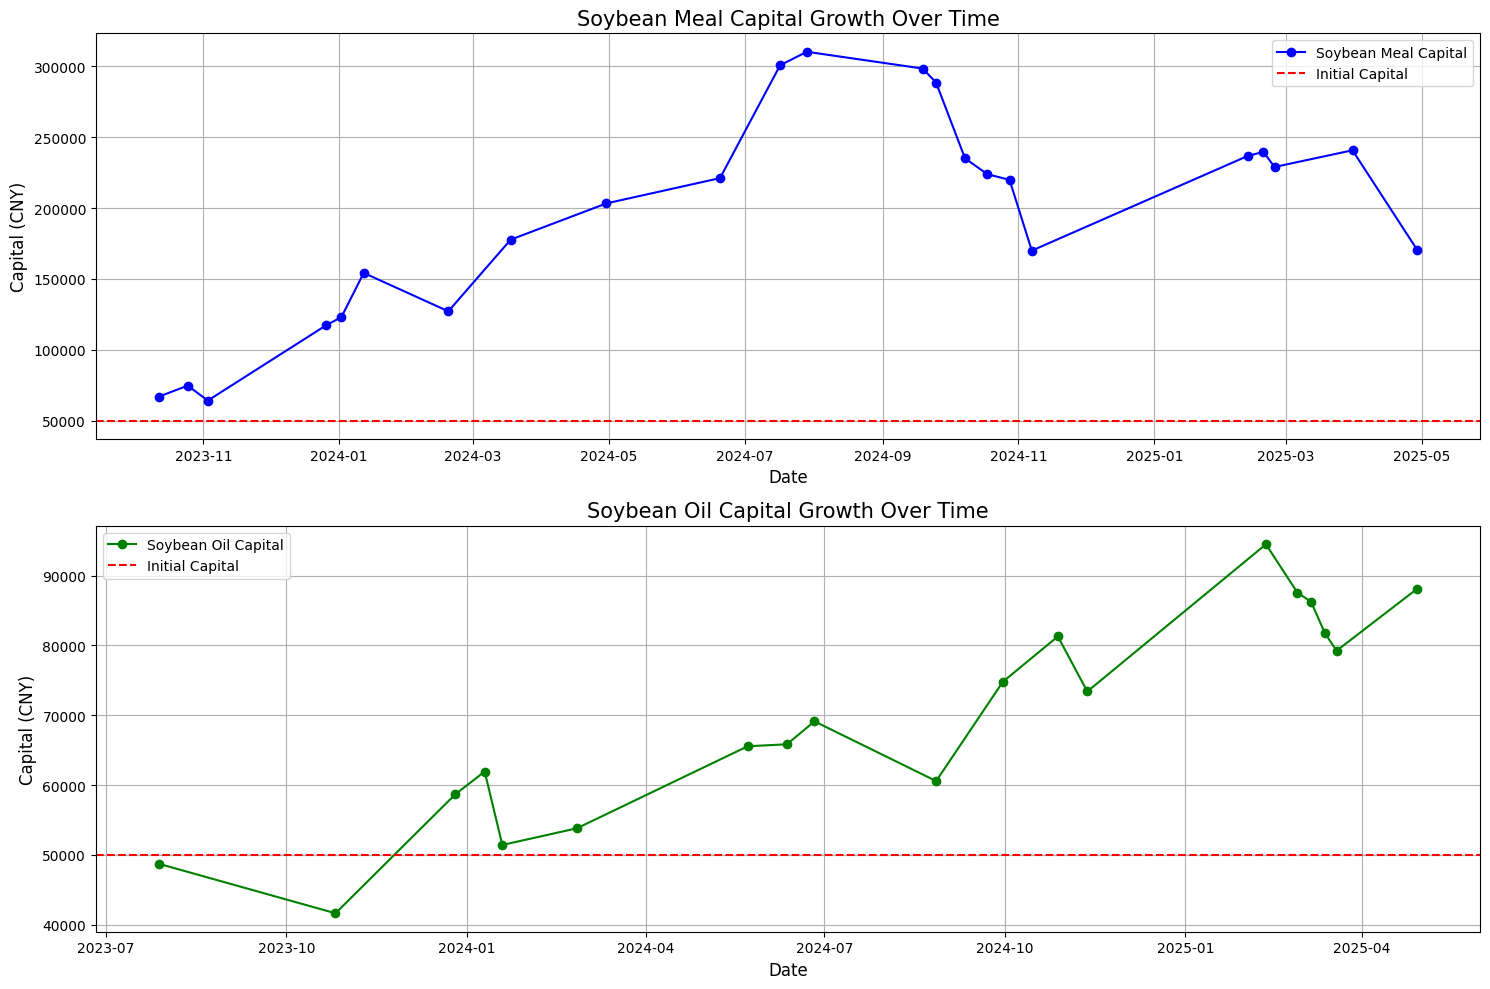

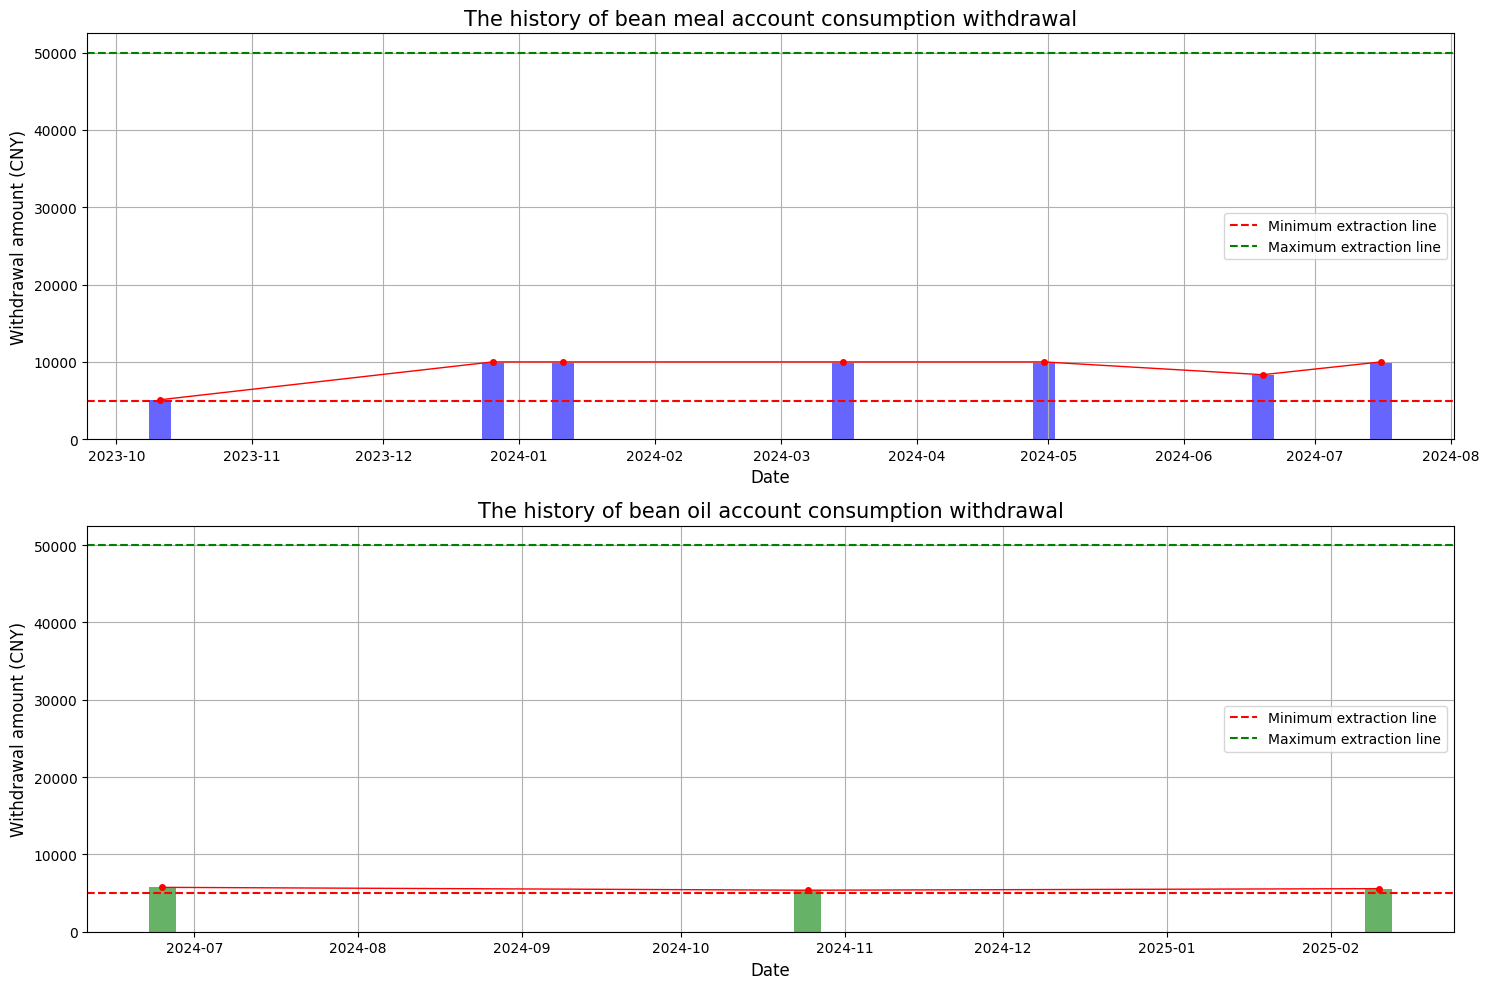

In [21]:
# Output Strategy Statistics
print("\n=== Statistics on soybean meal strategies ===")
print(f"Initial capital: {initial_capital:.2f}")
print(f"Final funds: {capital_meal:.2f}")
print(f"Total revenue: {total_profit_meal:.2f}")
print(f"Total consumption withdrawal: {total_consumption_meal:.2f}")
print(f"Annualized rate of return: {((capital_meal / initial_capital) ** (1 / 2) - 1) * 100:.2f}%")

print("\n=== Statistics on soybean oil strategies ===")
print(f"Initial capital: {initial_capital:.2f}")
print(f"Final funds: {capital_oil:.2f}")
print(f"Total revenue: {total_profit_oil:.2f}")
print(f"Total consumption withdrawal: {total_consumption_oil:.2f}")
print(f"Annualized rate of return: {((capital_oil / initial_capital) ** (1 / 2) - 1) * 100:.2f}%")

# Draw the capital curve
plt.figure(figsize=(15, 10))

# Soybean Meal Funding Curve
plt.subplot(2, 1, 1)
plt.plot(dates_history_meal, capital_history_meal, label='Soybean Meal Capital', color='blue', marker='o')
plt.axhline(y=initial_capital, color='red', linestyle='--', label='Initial Capital')
plt.title('Soybean Meal Capital Growth Over Time', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Capital (CNY)', fontsize=12)
plt.legend()
plt.grid(True)

# Soybean Oil Capital Curve
plt.subplot(2, 1, 2)
plt.plot(dates_history_oil, capital_history_oil, label='Soybean Oil Capital', color='green', marker='o')
plt.axhline(y=initial_capital, color='red', linestyle='--', label='Initial Capital')
plt.title('Soybean Oil Capital Growth Over Time', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Capital (CNY)', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# After drawing the capital curve, add the consumption withdrawal chart
plt.figure(figsize=(15, 10))

# Soybean Meal consumption extraction chart
plt.subplot(2, 1, 1)
if consumption_history_meal:  # Only draw when there is a consumption record
    plt.bar(consumption_dates_meal, consumption_history_meal, color='blue', alpha=0.6, width=5)
    plt.plot(consumption_dates_meal, consumption_history_meal, 'ro-', linewidth=1, markersize=4)
plt.axhline(y=5000, color='red', linestyle='--', label='Minimum extraction line')
plt.axhline(y=50000, color='green', linestyle='--', label='Maximum extraction line')
plt.title('The history of bean meal account consumption withdrawal', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Withdrawal amount (CNY)', fontsize=12)
plt.legend()
plt.grid(True)

# Soybean Oil consumption extraction chart
plt.subplot(2, 1, 2)
if consumption_history_oil:  # Only draw when there is a consumption record
    plt.bar(consumption_dates_oil, consumption_history_oil, color='green', alpha=0.6, width=5)
    plt.plot(consumption_dates_oil, consumption_history_oil, 'ro-', linewidth=1, markersize=4)
plt.axhline(y=5000, color='red', linestyle='--', label='Minimum extraction line')
plt.axhline(y=50000, color='green', linestyle='--', label='Maximum extraction line')
plt.title('The history of bean oil account consumption withdrawal', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Withdrawal amount (CNY)', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Performance metrics (**Sharpe**, **Max Drawdown**, **Win Rate**)

In [29]:
def _to_equity_series(dates, capital):
    """Make a pandas Series indexed by datetime for proper return math."""
    s = pd.Series(capital, index=pd.to_datetime(dates))
    s = s[~s.index.duplicated(keep="last")].sort_index()
    return s

def compute_returns(equity: pd.Series):
    """Discrete returns from equity curve."""
    rets = equity.pct_change().dropna()
    return rets

def sharpe_ratio(returns: pd.Series, risk_free_rate=0.0, periods_per_year=252):
    """
    Annualized Sharpe using simple returns.
    risk_free_rate: annual rf in decimal (e.g. 0.02 for 2%)
    """
    if returns.empty:
        return np.nan
    # convert rf to per-period
    rf_per_period = (1 + risk_free_rate) ** (1 / periods_per_year) - 1
    excess = returns - rf_per_period
    vol = excess.std(ddof=1)
    if vol == 0 or np.isnan(vol):
        return np.nan
    return (excess.mean() / vol) * sqrt(periods_per_year)

def max_drawdown(equity: pd.Series):
    """Max drawdown as negative number (e.g. -0.35 means -35%)."""
    if equity.empty:
        return np.nan, None, None
    roll_max = equity.cummax()
    drawdown = equity / roll_max - 1.0
    mdd = drawdown.min()
    # locate start/end (peak to trough)
    end = drawdown.idxmin() if not drawdown.empty else None
    start = (equity.loc[:end].idxmax() if end is not None else None)
    return mdd, start, end

def win_rate_from_trades(trade_pnls):
    """Win rate from a list/array of trade PnLs."""
    pnl = pd.Series(trade_pnls, dtype=float)
    if pnl.empty:
        return np.nan
    return (pnl > 0).mean()

def win_rate_from_daily(returns: pd.Series):
    """Fallback: percentage of positive daily returns."""
    if returns.empty:
        return np.nan
    return (returns > 0).mean()

def print_performance_block(name, dates, capital, 
                            trade_pnls=None, 
                            risk_free_rate=0.0, 
                            periods_per_year=252):
    equity = _to_equity_series(dates, capital)
    rets = compute_returns(equity)

    sr = sharpe_ratio(rets, risk_free_rate=risk_free_rate, periods_per_year=periods_per_year)
    mdd, mdd_start, mdd_end = max_drawdown(equity)
    if trade_pnls is not None:
        wr = win_rate_from_trades(trade_pnls)
    else:
        wr = win_rate_from_daily(rets)

    # Pretty printing
    print(f"\n=== Performance metrics — {name} ===")
    print(f"Sharpe Ratio (annualized): {sr:.3f}" if pd.notna(sr) else "Sharpe Ratio (annualized): N/A")
    if pd.notna(mdd):
        mdd_pct = mdd * 100
        print(f"Max Drawdown: {mdd_pct:.2f}%"
              + (f" (peak {mdd_start.date()} → trough {mdd_end.date()})" if (mdd_start and mdd_end) else ""))
    else:
        print("Max Drawdown: N/A")
    print(f"Win Rate: {wr*100:.2f}%" if pd.notna(wr) else "Win Rate: N/A")

# ===== Choose your calendar convention =====
# If it is daily frequency backtesting, 252 is commonly used; If it is a weekly frequency, 52 can be used. If it's a monthly frequency, 12 can be used.
PERIODS_PER_YEAR = 252
RISK_FREE = 0.02  # If an annualized risk-free interest rate of 2% is required, set it to 0.02

# ===== If you have trade PnL lists, provide them; otherwise leave as None =====
# Example placeholders (remove if you already have real lists):
# trade_pnls_meal = [...]
# trade_pnls_oil = [...]

# ===== Print metrics for both legs =====
print_performance_block(
    name="Soybean Meal",
    dates=dates_history_meal,
    capital=capital_history_meal,
    trade_pnls=(trade_pnls_meal if 'trade_pnls_meal' in globals() else None),
    risk_free_rate=RISK_FREE,
    periods_per_year=PERIODS_PER_YEAR
)

print_performance_block(
    name="Soybean Oil",
    dates=dates_history_oil,
    capital=capital_history_oil,
    trade_pnls=(trade_pnls_oil if 'trade_pnls_oil' in globals() else None),
    risk_free_rate=RISK_FREE,
    periods_per_year=PERIODS_PER_YEAR
)


=== Performance metrics — Soybean Meal ===
Sharpe Ratio (annualized): 4.305
Max Drawdown: -45.23% (peak 2024-07-29 → trough 2024-11-07)
Win Rate: 54.55%

=== Performance metrics — Soybean Oil ===
Sharpe Ratio (annualized): 4.418
Max Drawdown: -16.98% (peak 2024-01-10 → trough 2024-01-19)
Win Rate: 55.56%


## Saving Trading Reports

In [30]:
def compute_metrics(name, dates, capital, initial_capital, trade_pnls=None,
                    risk_free_rate=0.02, periods_per_year=252,
                    user_years=2.0):
    """
    Calculate and return a dict, including Sharpe, MDD, WR, annualized returns (in two formats), etc.
    -user_years: Reuse the "2 years" caliber of your original code and keep the comparison
    """
    equity = _to_equity_series(dates, capital)
    rets = compute_returns(equity)

    # Sharpe
    sr = sharpe_ratio(rets, risk_free_rate=risk_free_rate, periods_per_year=periods_per_year)

    # MDD
    mdd, mdd_start, mdd_end = max_drawdown(equity)
    mdd_pct = float(mdd) * 100 if pd.notna(mdd) else np.nan

    # Win Rate
    if trade_pnls is not None:
        wr = win_rate_from_trades(trade_pnls)
    else:
        wr = win_rate_from_daily(rets)
    wr_pct = float(wr) * 100 if pd.notna(wr) else np.nan

    # Annualized Return (Two Methods)
    # 1) Keep using your original stance: Assume two years
    ann_return_user = ((equity.iloc[-1] / initial_capital) ** (1.0 / user_years) - 1.0) * 100.0

    # 2) CAGR for automatically calculating years based on start and end dates (more robust)
    if len(equity) >= 2:
        years_exact = (equity.index[-1] - equity.index[0]).days / 365.2425
        years_exact = max(years_exact, 1e-9)
        ann_return_cagr = ((equity.iloc[-1] / initial_capital) ** (1.0 / years_exact) - 1.0) * 100.0
    else:
        ann_return_cagr = np.nan

    # Calmar (use CAGR / |MDD|)
    calmar = (ann_return_cagr / abs(mdd_pct)) if (pd.notna(ann_return_cagr) and pd.notna(mdd_pct) and abs(mdd_pct) > 1e-12) else np.nan

    return {
        "Strategy": name,
        "Start Date": equity.index[0].date() if len(equity) else None,
        "End Date": equity.index[-1].date() if len(equity) else None,
        "Initial Capital": float(initial_capital),
        "Final Funds": float(equity.iloc[-1]) if len(equity) else float(initial_capital),
        "Total Profit": float((equity.iloc[-1] - initial_capital)) if len(equity) else 0.0,
        "Annualized Return (user_formula)": float(ann_return_user),
        "CAGR (by dates)": float(ann_return_cagr) if pd.notna(ann_return_cagr) else np.nan,
        "Sharpe Ratio": float(sr) if pd.notna(sr) else np.nan,
        "Max Drawdown (%)": float(mdd_pct) if pd.notna(mdd_pct) else np.nan,
        "Win Rate (%)": float(wr_pct) if pd.notna(wr_pct) else np.nan,
        "Calmar Ratio": float(calmar) if pd.notna(calmar) else np.nan
    }

# ============ generate and save the report ============

# Directory and File Name
save_dir = "reports/backtests"
os.makedirs(save_dir, exist_ok=True)
stamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Summary Metrics (Take values from your existing variables)
# Optional trade_pnls_meal/trade_pnls_oil. If not defined, None will be passed
trade_pnls_meal_ = trade_pnls_meal if 'trade_pnls_meal' in globals() else None
trade_pnls_oil_  = trade_pnls_oil  if 'trade_pnls_oil'  in globals() else None

summary_meal = compute_metrics(
    name="Soybean Meal",
    dates=dates_history_meal,
    capital=capital_history_meal,
    initial_capital=initial_capital,
    trade_pnls=trade_pnls_meal_,
    risk_free_rate=RISK_FREE,
    periods_per_year=PERIODS_PER_YEAR,
    user_years=2.0
)

summary_oil = compute_metrics(
    name="Soybean Oil",
    dates=dates_history_oil,
    capital=capital_history_oil,
    initial_capital=initial_capital,
    trade_pnls=trade_pnls_oil_,
    risk_free_rate=RISK_FREE,
    periods_per_year=PERIODS_PER_YEAR,
    user_years=2.0
)

df_summary = pd.DataFrame([summary_meal, summary_oil])
summary_path = os.path.join(save_dir, f"backtest_summary_{stamp}.csv")
df_summary.to_csv(summary_path, index=False, float_format="%.6f")

# Capital Curve (Exported by date alignment for easy reuse later)
equity_meal = _to_equity_series(dates_history_meal, capital_history_meal)
equity_oil  = _to_equity_series(dates_history_oil,  capital_history_oil)
df_equity = pd.DataFrame({
    "Date": pd.to_datetime(sorted(set(equity_meal.index).union(set(equity_oil.index))))
}).set_index("Date")

df_equity["Meal_Capital"] = equity_meal.reindex(df_equity.index).ffill()
df_equity["Oil_Capital"]  = equity_oil.reindex(df_equity.index).ffill()
equity_path = os.path.join(save_dir, f"backtest_equity_{stamp}.csv")
df_equity.to_csv(equity_path, float_format="%.6f")

# If there are any records of cash withdrawal for consumption, export them
def _maybe_series(dates, values):
    if dates is None or values is None: 
        return None
    if len(dates) == 0 or len(values) == 0:
        return None
    s = pd.Series(values, index=pd.to_datetime(dates)).sort_index()
    return s

cons_meal = _maybe_series(
    consumption_dates_meal if 'consumption_dates_meal' in globals() else [],
    consumption_history_meal if 'consumption_history_meal' in globals() else []
)
cons_oil = _maybe_series(
    consumption_dates_oil if 'consumption_dates_oil' in globals() else [],
    consumption_history_oil if 'consumption_history_oil' in globals() else []
)

if cons_meal is not None:
    df_cons_meal = cons_meal.rename("Meal_Withdrawal").to_frame()
    df_cons_meal.index.name = "Date"
    cons_meal_path = os.path.join(save_dir, f"consumption_meal_{stamp}.csv")
    df_cons_meal.to_csv(cons_meal_path, float_format="%.6f")

if cons_oil is not None:
    df_cons_oil = cons_oil.rename("Oil_Withdrawal").to_frame()
    df_cons_oil.index.name = "Date"
    cons_oil_path = os.path.join(save_dir, f"consumption_oil_{stamp}.csv")
    df_cons_oil.to_csv(cons_oil_path, float_format="%.6f")

print("\n Reports saved:")
print(f"- Summary: {summary_path}")
print(f"- Equity:  {equity_path}")
if cons_meal is not None:
    print(f"- Meal withdrawals: {cons_meal_path}")
if cons_oil is not None:
    print(f"- Oil withdrawals:  {cons_oil_path}")



 Reports saved:
- Summary: reports/backtests\backtest_summary_20250826_092139.csv
- Equity:  reports/backtests\backtest_equity_20250826_092139.csv
- Meal withdrawals: reports/backtests\consumption_meal_20250826_092139.csv
- Oil withdrawals:  reports/backtests\consumption_oil_20250826_092139.csv
